In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster, cophenet
import scipy.cluster.hierarchy as sch
from sklearn.metrics import adjusted_rand_score, silhouette_score, adjusted_mutual_info_score
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
def pearson_COR(spec1,spec2):
    pcorr, _ = pearsonr(spec1,spec2)
    return pcorr

def spearman_COR(spec1,spec2):
    scorr, _ = spearmanr(spec1,spec2)
    return scorr

def Pearson_matrix(df,i0):
    COR_pearson = pd.DataFrame()
    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
            COR_pearson.loc[i,j] =pearson_COR(df.iloc[i,i0:],df.iloc[j,i0:])
    return COR_pearson

def Spearman_matrix(df,i0):
    COR__spearman= pd.DataFrame()
    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
            COR__spearman.loc[i,j] =spearman_COR(df.iloc[i,i0:],df.iloc[j,i0:])
    return COR__spearman

In [9]:
def Union(list1, list2):
    final_list = sorted(set(list1) | set(list2))
    return final_list

In [3]:
path = "/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/ML results/"

### Feature importance score calculated with k-fold iteration with or without SMOTE
Sorted by mean_score

In [4]:
def get_feature_rank(filename):
    score = pd.read_csv(path+filename)
    features_sorted = np.array(score.sort_values(by=['mean_score'],ascending=False).features)
    features_sorted = [str(int(item)) for item in features_sorted]
    return features_sorted

In [5]:
SPEC_sorted = get_feature_rank("Feature importance score SPEC.csv")
Lap_sorted = get_feature_rank("Feature importance score Lap.csv")
NDFS_sorted = get_feature_rank("Feature importance score NDFS.csv")
UDFS_sorted = get_feature_rank("Feature importance score UDFS.csv")

SPEC_SMOTE_sorted = get_feature_rank("Feature importance score SPEC - SMOTE.csv")
Lap_SMOTE_sorted = get_feature_rank("Feature importance score Lap - SMOTE.csv")
NDFS_SMOTE_sorted = get_feature_rank("Feature importance score NDFS - SMOTE.csv")
UDFS_SMOTE_sorted = get_feature_rank("Feature importance score UDFS - SMOTE.csv")

In [113]:
NDFS_sorted[0:10]

['1526',
 '1528',
 '1746',
 '2904',
 '1702',
 '1658',
 '3568',
 '1282',
 '1660',
 '1674']

In [114]:
NDFS_SMOTE_sorted[0:10]

['1526',
 '1746',
 '1658',
 '1528',
 '1660',
 '2904',
 '1770',
 '3570',
 '3568',
 '2902']

### Wither SMOTE cause selectors to pick different features
* score = (#of unshared features)/(total number of selected features) 
* Higher the score, larger degree of diversity in SMOTE

In [128]:
def shared_ratio(list1, list2):
    dissimilarity_ratio = []
    for n in n_features:
        #print(n)
        set1 = set(list1[0:n])
        set2 = set(list2[0:n])
        Intersection = set1.intersection(set2)
        dissimilarity_ratio.append((n-len(Intersection))/n)
    return dissimilarity_ratio

In [102]:
n_features = range(10,1000,10)

99

In [133]:
df_result = pd.DataFrame()
df_result['n_features'] = n_features

In [134]:
df_result['SPEC_ratio'] = shared_ratio(SPEC_sorted, SPEC_SMOTE_sorted)
df_result['LS_ratio'] = shared_ratio(Lap_sorted, Lap_SMOTE_sorted)
df_result['UDFS_ratio'] = shared_ratio(UDFS_sorted, UDFS_SMOTE_sorted)
df_result['NDFS_ratio'] = shared_ratio(NDFS_sorted, NDFS_SMOTE_sorted)

In [135]:
df_result

,n_features,SPEC_ratio,LS_ratio,UDFS_ratio,NDFS_ratio
0,10,0.600000,0.800000,0.200000,0.300000
1,20,0.750000,0.600000,0.200000,0.450000
2,30,0.766667,0.700000,0.400000,0.533333
3,40,0.800000,0.675000,0.525000,0.375000
4,50,0.740000,0.640000,0.520000,0.380000
...,...,...,...,...,...
94,950,0.120000,0.028421,0.016842,0.025263
95,960,0.118750,0.027083,0.014583,0.025000
96,970,0.112371,0.028866,0.007216,0.028866
97,980,0.107143,0.029592,0.002041,0.030612


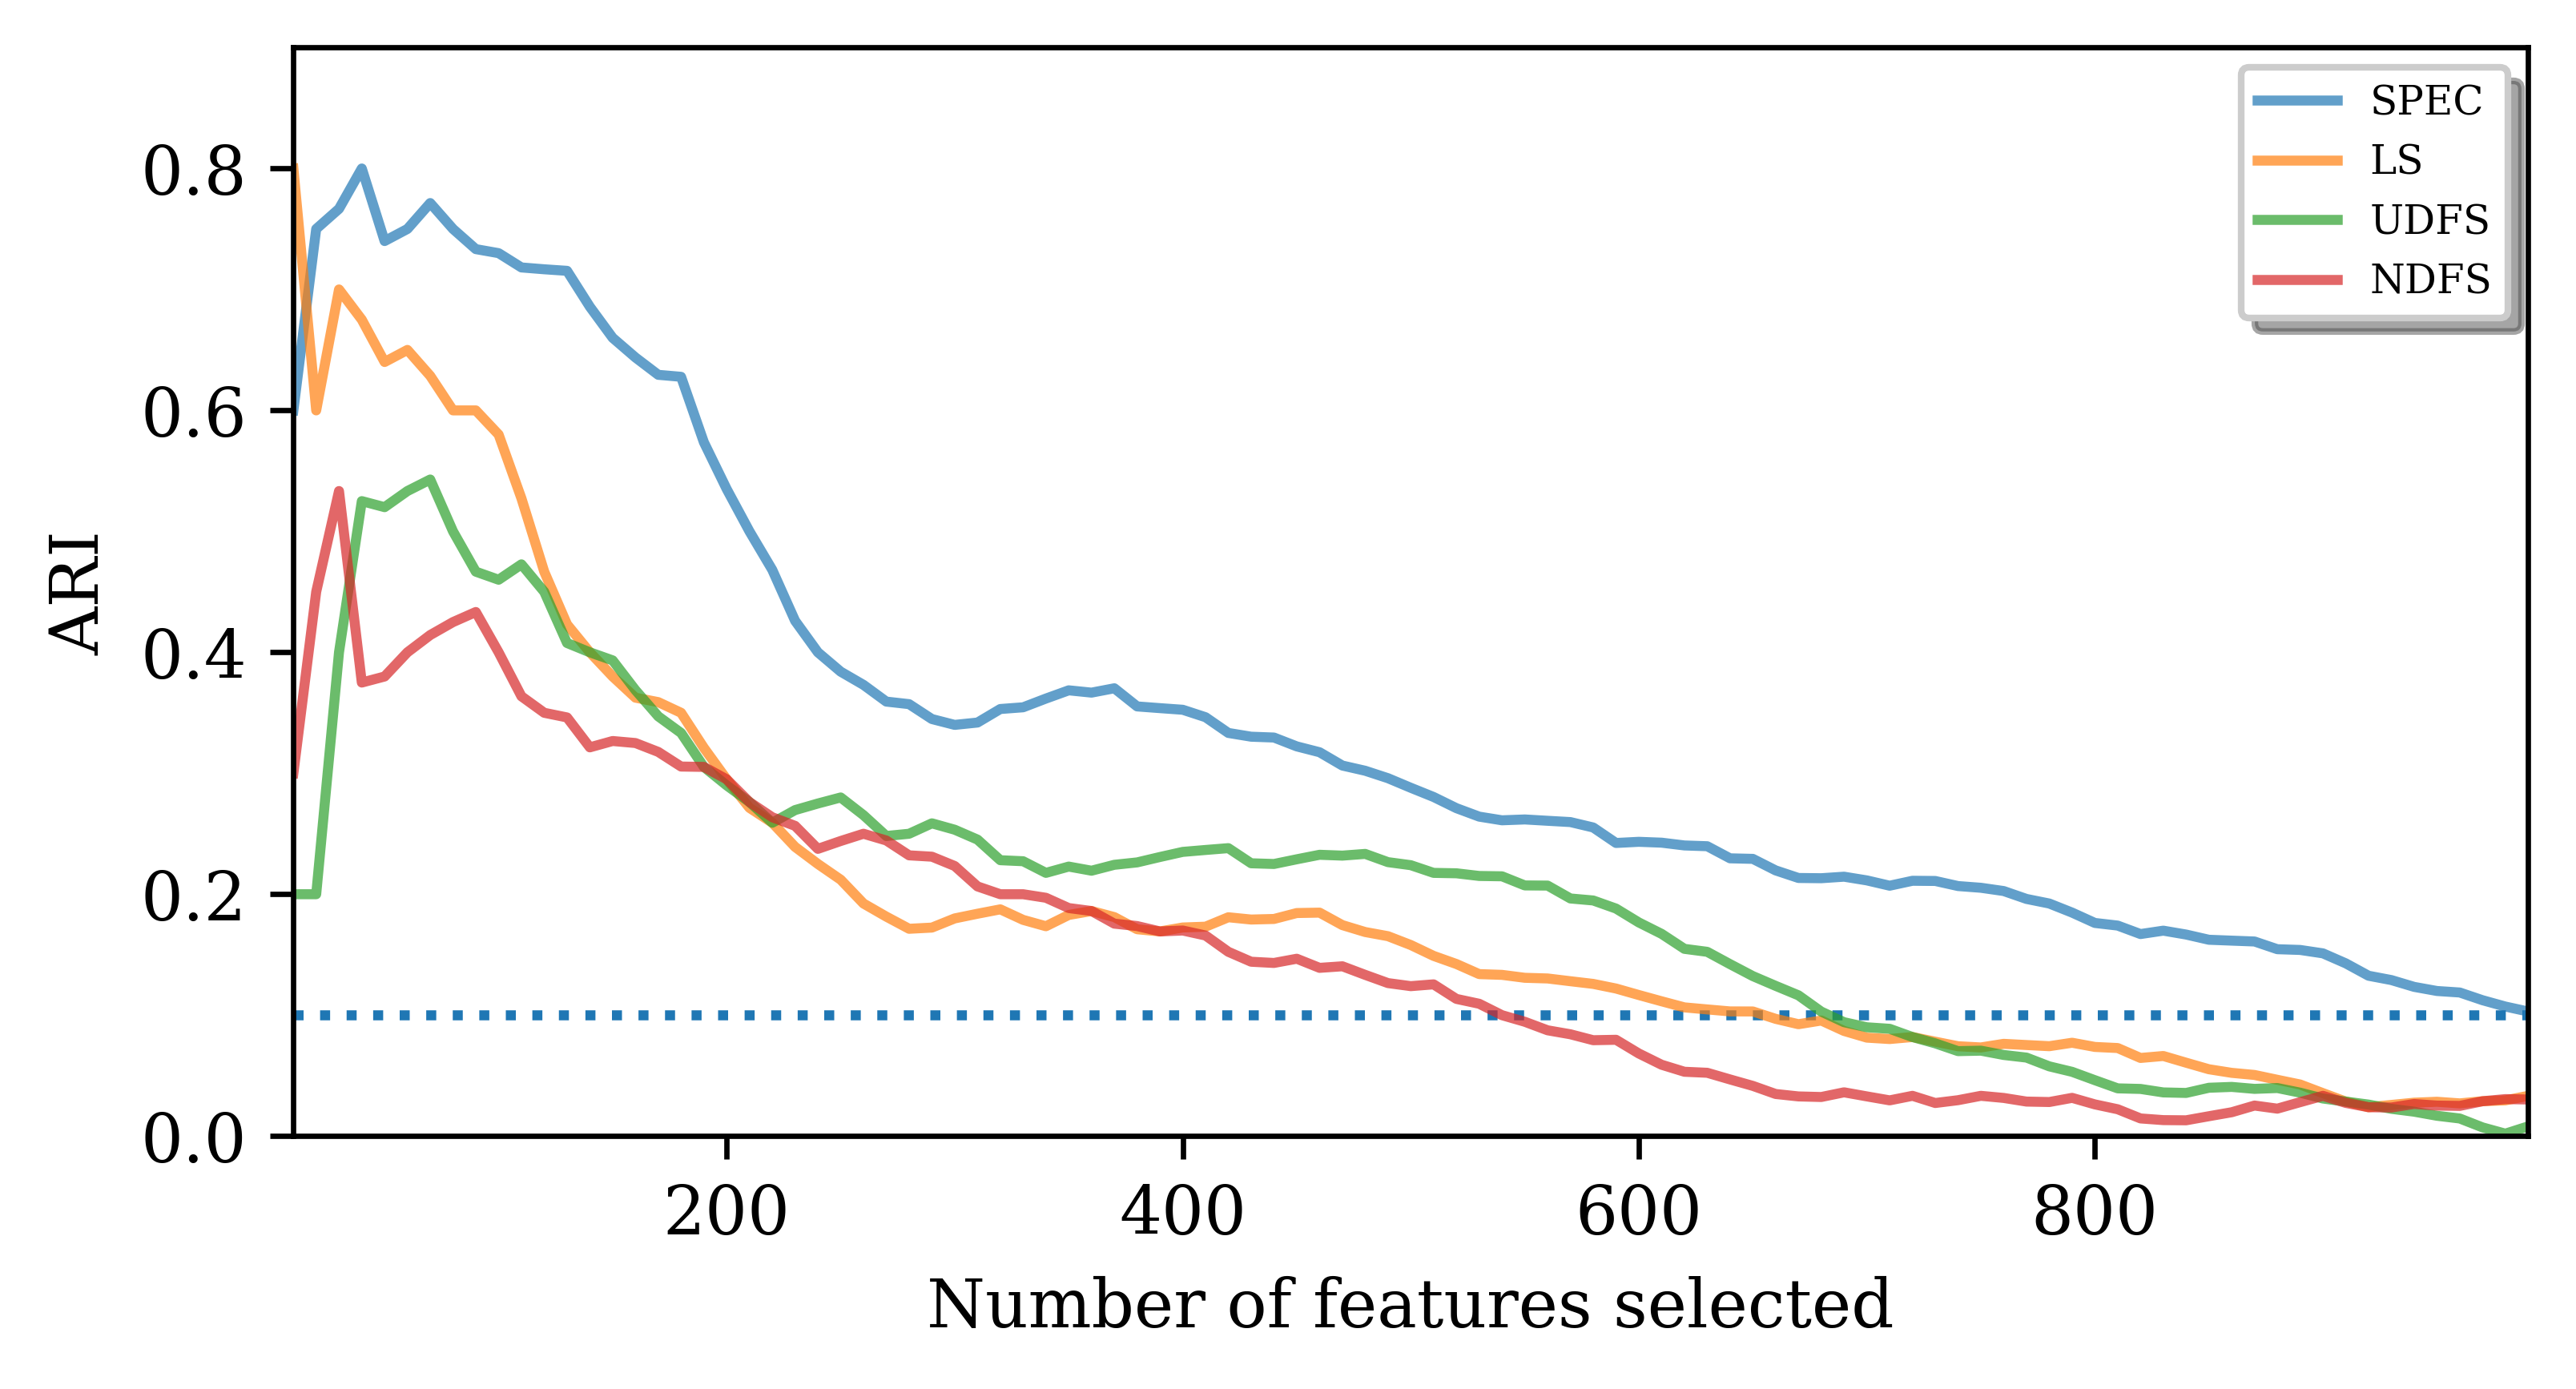

In [141]:
fig, ax = plt.subplots(figsize=(6,3), dpi=600)
plt.rc('font', family='serif', size = 10)
ax.set_xlabel('Number of features selected')
ax.set_ylabel('ARI')
ax.set_ylim(0,0.9)
ax.set_xlim(min(df_result.n_features),max(df_result.n_features))
ax.plot(df_result.n_features,df_result.SPEC_ratio, label = "SPEC", alpha=0.7)
ax.plot(df_result.n_features,df_result.LS_ratio	, label = "LS", alpha=0.7)
ax.plot(df_result.n_features,df_result.UDFS_ratio, label = "UDFS", alpha=0.7)
ax.plot(df_result.n_features,df_result.NDFS_ratio, label = "NDFS", alpha=0.7)
ax.hlines(0.1, min(df_result.n_features),max(df_result.n_features), linestyles="dotted")

plt.legend()
legend = plt.legend(loc='upper right', shadow=True, fontsize=6)
plt.show()
#fig.savefig(path+"Clustering ARI comparison Spearman, SMOTE.png", bbox_inches='tight')

### Load and k-fold split Dataset

In [23]:
df_variance = pd.read_csv(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset low variance.csv")
df = pd.read_csv(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset.csv")

In [514]:
df

,Drug,Class,400,402,404,406,408,410,412,414,...,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
0,Heroin_0,1.0,0.008913,0.008557,0.008188,0.007875,0.007665,0.007587,0.007654,0.007875,...,0.000005,0.000004,0.000004,0.000003,0.000003,0.000002,0.000002,1.023970e-06,5.107461e-07,0.0
1,Heroin_1,1.0,0.008733,0.008339,0.007896,0.007482,0.007154,0.006941,0.006856,0.006906,...,0.000004,0.000004,0.000003,0.000003,0.000002,0.000002,0.000001,9.826807e-07,4.901463e-07,0.0
2,Heroin_2,1.0,0.005678,0.006161,0.006725,0.007351,0.007996,0.008596,0.009096,0.009479,...,0.000004,0.000004,0.000003,0.000003,0.000002,0.000002,0.000001,9.367916e-07,4.672508e-07,0.0
3,Heroin_3,1.0,0.010488,0.009987,0.009345,0.008699,0.008146,0.007738,0.007495,0.007418,...,0.000004,0.000003,0.000003,0.000003,0.000002,0.000002,0.000001,8.597496e-07,4.288242e-07,0.0
4,Heroin_4,1.0,0.008211,0.008808,0.009531,0.010337,0.011142,0.011830,0.012298,0.012518,...,0.000005,0.000005,0.000004,0.000004,0.000003,0.000002,0.000002,1.189903e-06,5.935380e-07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,5-MeO-MiPT_2,16.0,0.115878,0.120075,0.122804,0.123737,0.122299,0.118178,0.111844,0.104397,...,0.000048,0.000042,0.000037,0.000031,0.000026,0.000021,0.000015,1.017230e-05,5.058586e-06,0.0
926,5-MeO-MiPT_3,16.0,0.071569,0.067204,0.062650,0.058600,0.055493,0.053512,0.052634,0.052652,...,0.000049,0.000043,0.000037,0.000032,0.000026,0.000021,0.000016,1.042104e-05,5.182941e-06,0.0
927,5-MeO-MiPT_4,16.0,0.044234,0.046283,0.049438,0.053815,0.059506,0.066518,0.074644,0.083303,...,0.000048,0.000043,0.000037,0.000032,0.000026,0.000021,0.000016,1.032727e-05,5.135880e-06,0.0
928,5-MeO-MiPT_5,16.0,0.035880,0.033944,0.032589,0.031806,0.031588,0.031941,0.032867,0.034350,...,0.000041,0.000036,0.000031,0.000027,0.000022,0.000018,0.000013,8.717246e-06,4.335987e-06,0.0


In [24]:
X = df_variance
Y = df['Class'].astype('int64')

features = []
for col in df_variance.columns:
    features.append(col)

len(features)
features = [float(item) for item in features]

In [25]:
kf=KFold(n_splits=5,shuffle=True,random_state=42)
X_train_base=[]
Y_train_base=[]
X_test_base=[]
Y_test_base=[]
for train_index, test_index in kf.split(df_variance):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    Y_train, Y_test = Y[train_index], Y[test_index] 
    X_train_base.append(X_train)
    Y_train_base.append(Y_train)

    X_test_base.append(X_test)
    Y_test_base.append(Y_test)

In [26]:
np.unique(Y_test_base[0],return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([ 3, 14, 14,  2, 12, 24, 13,  8,  2, 16,  3, 14, 14, 17, 21,  9]))

### Full range features clustering ARI and Sihouette using 5-fold split

In [244]:
def baseline(Correlation):
    ARI_sum = 0
    silhouette_sum = 0
    NMI_sum = 0
    for i in range(len(X_test_base)):
        print("Iteration round:", str(i+1))
        # Correlation coefficient matrix
        M = Correlation(X_test_base[i],0)
        Z = linkage(M.values, method='ward')
        cluster_nodes = fcluster(Z,16, criterion='maxclust')
        ARI = adjusted_rand_score(Y_test_base[i],cluster_nodes)
        silhouette = silhouette_score(M.values, cluster_nodes, metric='euclidean')
        NMI = adjusted_mutual_info_score(Y_test_base[i], cluster_nodes)
        ARI_sum = ARI_sum + ARI
        silhouette_sum = silhouette_sum + silhouette
        NMI_sum = NMI_sum + NMI
    return ARI_sum/len(X_test_base), silhouette_sum/len(X_test_base), NMI_sum/len(X_test_base)

In [245]:
baseline(Pearson_matrix)

Iteration round: 1
Iteration round: 2
Iteration round: 3
Iteration round: 4
Iteration round: 5


(0.4501282284804146, 0.31355101174940114, 0.6082598015684126)

In [246]:
baseline(Spearman_matrix)

Iteration round: 1
Iteration round: 2
Iteration round: 3
Iteration round: 4
Iteration round: 5


(0.4054628458966774, 0.3320191495856804, 0.5802540635003808)

### Compare feature ranking methods using hierarchical clustering and ARI

In [247]:
def evaluate_ARI(method, Correlation):
    ARI_result = []
    silhouette_result = []
    NMI_result = []
    for num_feat in features_select:
        print("Number of features selected:", num_feat)
        ARI_feature = 0
        silhouette_feature = 0
        NMI_feature = 0
        for i in range(len(X_test_base)):
            print("Iteration round:", str(i+1))
            # Subset selected features
            X_select = X_test_base[i].copy()
            X_select = X_select[method[0:num_feat]]
            #X_select = X_test_base[i][method[0:num_feat]]
            # Calculate correlation coefficient matrix
            M = Correlation(X_select,0)
            Z = linkage(M.values, method='ward')
            cluster_nodes = fcluster(Z,16, criterion='maxclust')
            ARI = adjusted_rand_score(Y_test_base[i],cluster_nodes)
            silhouette = silhouette_score(M.values, cluster_nodes, metric='euclidean')
            NMI = adjusted_mutual_info_score(Y_test_base[i], cluster_nodes)
            #print("ARI", ARI)
            #print("silhouette", silhouette)
            ARI_feature = ARI_feature + ARI
            silhouette_feature = silhouette_feature + silhouette
            NMI_feature = NMI_feature + NMI
            print(num_feat," subset X_test done")
        ARI_result.append(ARI_feature/len(X_test_base))
        silhouette_result.append(silhouette_feature/len(X_test_base))
        NMI_result.append(NMI_feature/len(X_test_base))
    return ARI_result, silhouette_result, NMI_result

In [301]:
features_select =np.arange(1040, 1080, 10)
#features_select= np.append(features_select, 1181)
print(len(features_select))
print("Numbers of selected features set:", features_select)

4
Numbers of selected features set: [1040 1050 1060 1070]


In [302]:
df_refine = pd.DataFrame()
df_refine['num_feat'] = features_select
df_refine['ARI'], df_refine['silhouette'], df_refine['NMI']= evaluate_ARI(SPEC_sorted, Pearson_matrix)

Number of features selected: 1040
Iteration round: 1
1040  subset X_test done
Iteration round: 2
1040  subset X_test done
Iteration round: 3
1040  subset X_test done
Iteration round: 4
1040  subset X_test done
Iteration round: 5
1040  subset X_test done
Number of features selected: 1050
Iteration round: 1
1050  subset X_test done
Iteration round: 2
1050  subset X_test done
Iteration round: 3
1050  subset X_test done
Iteration round: 4
1050  subset X_test done
Iteration round: 5
1050  subset X_test done
Number of features selected: 1060
Iteration round: 1
1060  subset X_test done
Iteration round: 2
1060  subset X_test done
Iteration round: 3
1060  subset X_test done
Iteration round: 4
1060  subset X_test done
Iteration round: 5
1060  subset X_test done
Number of features selected: 1070
Iteration round: 1
1070  subset X_test done
Iteration round: 2
1070  subset X_test done
Iteration round: 3
1070  subset X_test done
Iteration round: 4
1070  subset X_test done
Iteration round: 5
1070  sub

In [303]:
df_refine[df_refine['ARI']==max(df_refine['ARI'])]

,num_feat,ARI,silhouette,NMI
1,1050,0.490195,0.314259,0.630744


In [304]:
df_refine[df_refine['NMI']==max(df_refine['NMI'])]

,num_feat,ARI,silhouette,NMI
2,1060,0.489278,0.313506,0.635054


### With SMOTE, Spearman

In [44]:
df_result = pd.DataFrame()
df_result['num_feat'] = features_select

In [45]:
df_result['SPEC_ARI']=evaluate_ARI(SPEC_SMOTE_sorted, Spearman_matrix)

Number of features selected: 10
Iteration round: 1
0.2350710549264154
10  subset X_test done
Iteration round: 2
0.18835421927365856
10  subset X_test done
Iteration round: 3
0.24596969392337756
10  subset X_test done
Iteration round: 4
0.24411010247940299
10  subset X_test done
Iteration round: 5
0.275040210557099
10  subset X_test done
Number of features selected: 40
Iteration round: 1
0.1617652034901706
40  subset X_test done
Iteration round: 2
0.14483239074159326
40  subset X_test done
Iteration round: 3
0.1528790330398722
40  subset X_test done
Iteration round: 4
0.1611427063682064
40  subset X_test done
Iteration round: 5
0.17944776917304173
40  subset X_test done
Number of features selected: 70
Iteration round: 1
0.16990472395234882
70  subset X_test done
Iteration round: 2
0.1328989036281962
70  subset X_test done
Iteration round: 3
0.13851477563381626
70  subset X_test done
Iteration round: 4
0.17181978564898742
70  subset X_test done
Iteration round: 5
0.20097415511119
70  sub

0.34838656177552957
700  subset X_test done
Number of features selected: 730
Iteration round: 1
0.36898113915227493
730  subset X_test done
Iteration round: 2
0.32786303229854263
730  subset X_test done
Iteration round: 3
0.3639152935401788
730  subset X_test done
Iteration round: 4
0.327334393975334
730  subset X_test done
Iteration round: 5
0.3931428235244023
730  subset X_test done
Number of features selected: 760
Iteration round: 1
0.34091798744082086
760  subset X_test done
Iteration round: 2
0.3238938430207738
760  subset X_test done
Iteration round: 3
0.36481608174586627
760  subset X_test done
Iteration round: 4
0.3287791348343609
760  subset X_test done
Iteration round: 5
0.39057737178990415
760  subset X_test done
Number of features selected: 790
Iteration round: 1
0.3933477692287904
790  subset X_test done
Iteration round: 2
0.3151172135769423
790  subset X_test done
Iteration round: 3
0.40719412968075436
790  subset X_test done
Iteration round: 4
0.35158567826035514
790  su

In [46]:
df_result['Lap_ARI']=evaluate_ARI(Lap_SMOTE_sorted, Spearman_matrix)

Number of features selected: 10
Iteration round: 1
0.13738690722484342
10  subset X_test done
Iteration round: 2
0.15131851991988576
10  subset X_test done
Iteration round: 3
0.15429742991325907
10  subset X_test done
Iteration round: 4
0.16089781208835255
10  subset X_test done
Iteration round: 5
0.14807228364674804
10  subset X_test done
Number of features selected: 40
Iteration round: 1
0.23865183019069577
40  subset X_test done
Iteration round: 2
0.30846022963477177
40  subset X_test done
Iteration round: 3
0.35983580377644714
40  subset X_test done
Iteration round: 4
0.23981019120865613
40  subset X_test done
Iteration round: 5
0.29527219497059665
40  subset X_test done
Number of features selected: 70
Iteration round: 1
0.2534518858572959
70  subset X_test done
Iteration round: 2
0.3291482312001328
70  subset X_test done
Iteration round: 3
0.3000351695086459
70  subset X_test done
Iteration round: 4
0.2651443729656197
70  subset X_test done
Iteration round: 5
0.30746974719893777
7

0.39455862862110064
700  subset X_test done
Number of features selected: 730
Iteration round: 1
0.4253990778423626
730  subset X_test done
Iteration round: 2
0.4021671403654324
730  subset X_test done
Iteration round: 3
0.5868291054851498
730  subset X_test done
Iteration round: 4
0.46411920336008683
730  subset X_test done
Iteration round: 5
0.47510758057472
730  subset X_test done
Number of features selected: 760
Iteration round: 1
0.4683989011743688
760  subset X_test done
Iteration round: 2
0.3215467771304231
760  subset X_test done
Iteration round: 3
0.5797251908396946
760  subset X_test done
Iteration round: 4
0.4546465921775022
760  subset X_test done
Iteration round: 5
0.40681076687468326
760  subset X_test done
Number of features selected: 790
Iteration round: 1
0.4508227228681323
790  subset X_test done
Iteration round: 2
0.40097989733148426
790  subset X_test done
Iteration round: 3
0.5767177858677008
790  subset X_test done
Iteration round: 4
0.44032515936130895
790  subset

In [47]:
df_result['UDFS_ARI']=evaluate_ARI(UDFS_SMOTE_sorted, Spearman_matrix)

Number of features selected: 10
Iteration round: 1
0.02898057093768379
10  subset X_test done
Iteration round: 2
0.03956583796891599
10  subset X_test done
Iteration round: 3
0.010595713227518915
10  subset X_test done
Iteration round: 4
0.027884242229030777
10  subset X_test done
Iteration round: 5
0.019393015088121822
10  subset X_test done
Number of features selected: 40
Iteration round: 1
0.19381975925835637
40  subset X_test done
Iteration round: 2
0.2381268198158373
40  subset X_test done
Iteration round: 3
0.18317220325965342
40  subset X_test done
Iteration round: 4
0.20708591803802193
40  subset X_test done
Iteration round: 5
0.24628897646439593
40  subset X_test done
Number of features selected: 70
Iteration round: 1
0.32605526403682594
70  subset X_test done
Iteration round: 2
0.273775616312365
70  subset X_test done
Iteration round: 3
0.3076976769618227
70  subset X_test done
Iteration round: 4
0.35598426615778817
70  subset X_test done
Iteration round: 5
0.2961588956480077

0.33550686118534356
700  subset X_test done
Number of features selected: 730
Iteration round: 1
0.3489195618899871
730  subset X_test done
Iteration round: 2
0.2539135496523677
730  subset X_test done
Iteration round: 3
0.34739185290966984
730  subset X_test done
Iteration round: 4
0.29340086968987433
730  subset X_test done
Iteration round: 5
0.34675124214500425
730  subset X_test done
Number of features selected: 760
Iteration round: 1
0.3592608198631893
760  subset X_test done
Iteration round: 2
0.2522647408913994
760  subset X_test done
Iteration round: 3
0.41609122242087354
760  subset X_test done
Iteration round: 4
0.28808280079027476
760  subset X_test done
Iteration round: 5
0.36106311803375496
760  subset X_test done
Number of features selected: 790
Iteration round: 1
0.3786758292465221
790  subset X_test done
Iteration round: 2
0.3072839160185384
790  subset X_test done
Iteration round: 3
0.4283775940119804
790  subset X_test done
Iteration round: 4
0.29514563438713387
790  s

In [48]:
df_result['NDFS_ARI']=evaluate_ARI(NDFS_SMOTE_sorted, Spearman_matrix)

Number of features selected: 10
Iteration round: 1
0.16336782118967916
10  subset X_test done
Iteration round: 2
0.14221274603272133
10  subset X_test done
Iteration round: 3
0.16164754626847616
10  subset X_test done
Iteration round: 4
0.1752973633243601
10  subset X_test done
Iteration round: 5
0.1820778155886419
10  subset X_test done
Number of features selected: 40
Iteration round: 1
0.4219613830522133
40  subset X_test done
Iteration round: 2
0.31931323858854765
40  subset X_test done
Iteration round: 3
0.41935583913830204
40  subset X_test done
Iteration round: 4
0.3615461234679177
40  subset X_test done
Iteration round: 5
0.3872090263536052
40  subset X_test done
Number of features selected: 70
Iteration round: 1
0.2890065834754354
70  subset X_test done
Iteration round: 2
0.4293058737825601
70  subset X_test done
Iteration round: 3
0.491998749423267
70  subset X_test done
Iteration round: 4
0.4486525445911079
70  subset X_test done
Iteration round: 5
0.4425773120425488
70  subs

0.4859981791354033
700  subset X_test done
Number of features selected: 730
Iteration round: 1
0.4313981996184981
730  subset X_test done
Iteration round: 2
0.422391785245023
730  subset X_test done
Iteration round: 3
0.5671532001396719
730  subset X_test done
Iteration round: 4
0.4659135727233458
730  subset X_test done
Iteration round: 5
0.43066249842327214
730  subset X_test done
Number of features selected: 760
Iteration round: 1
0.4427815805705827
760  subset X_test done
Iteration round: 2
0.3611409607785921
760  subset X_test done
Iteration round: 3
0.5520058164013963
760  subset X_test done
Iteration round: 4
0.38813739334692265
760  subset X_test done
Iteration round: 5
0.41629506614009365
760  subset X_test done
Number of features selected: 790
Iteration round: 1
0.4343041068948177
790  subset X_test done
Iteration round: 2
0.3516166350934141
790  subset X_test done
Iteration round: 3
0.5633259127499495
790  subset X_test done
Iteration round: 4
0.33460252255762596
790  subset

In [49]:
df_result

,num_feat,SPEC_ARI,Lap_ARI,UDFS_ARI,NDFS_ARI
0,10,0.237709,0.150395,0.025284,0.164921
1,40,0.160013,0.288406,0.213699,0.381877
2,70,0.162822,0.291050,0.311934,0.420308
3,100,0.169155,0.267913,0.333850,0.442241
4,130,0.140330,0.271848,0.354728,0.426176
5,160,0.147778,0.275878,0.364287,0.464507
6,190,0.167459,0.271112,0.367401,0.446874
7,220,0.179680,0.283854,0.322697,0.462444
8,250,0.174411,0.284481,0.254779,0.449385
9,280,0.163067,0.289382,0.289443,0.441865


In [50]:
df_result.to_csv(path+"Clustering ARI comparison Spearman, SMOTE.csv",index=False)

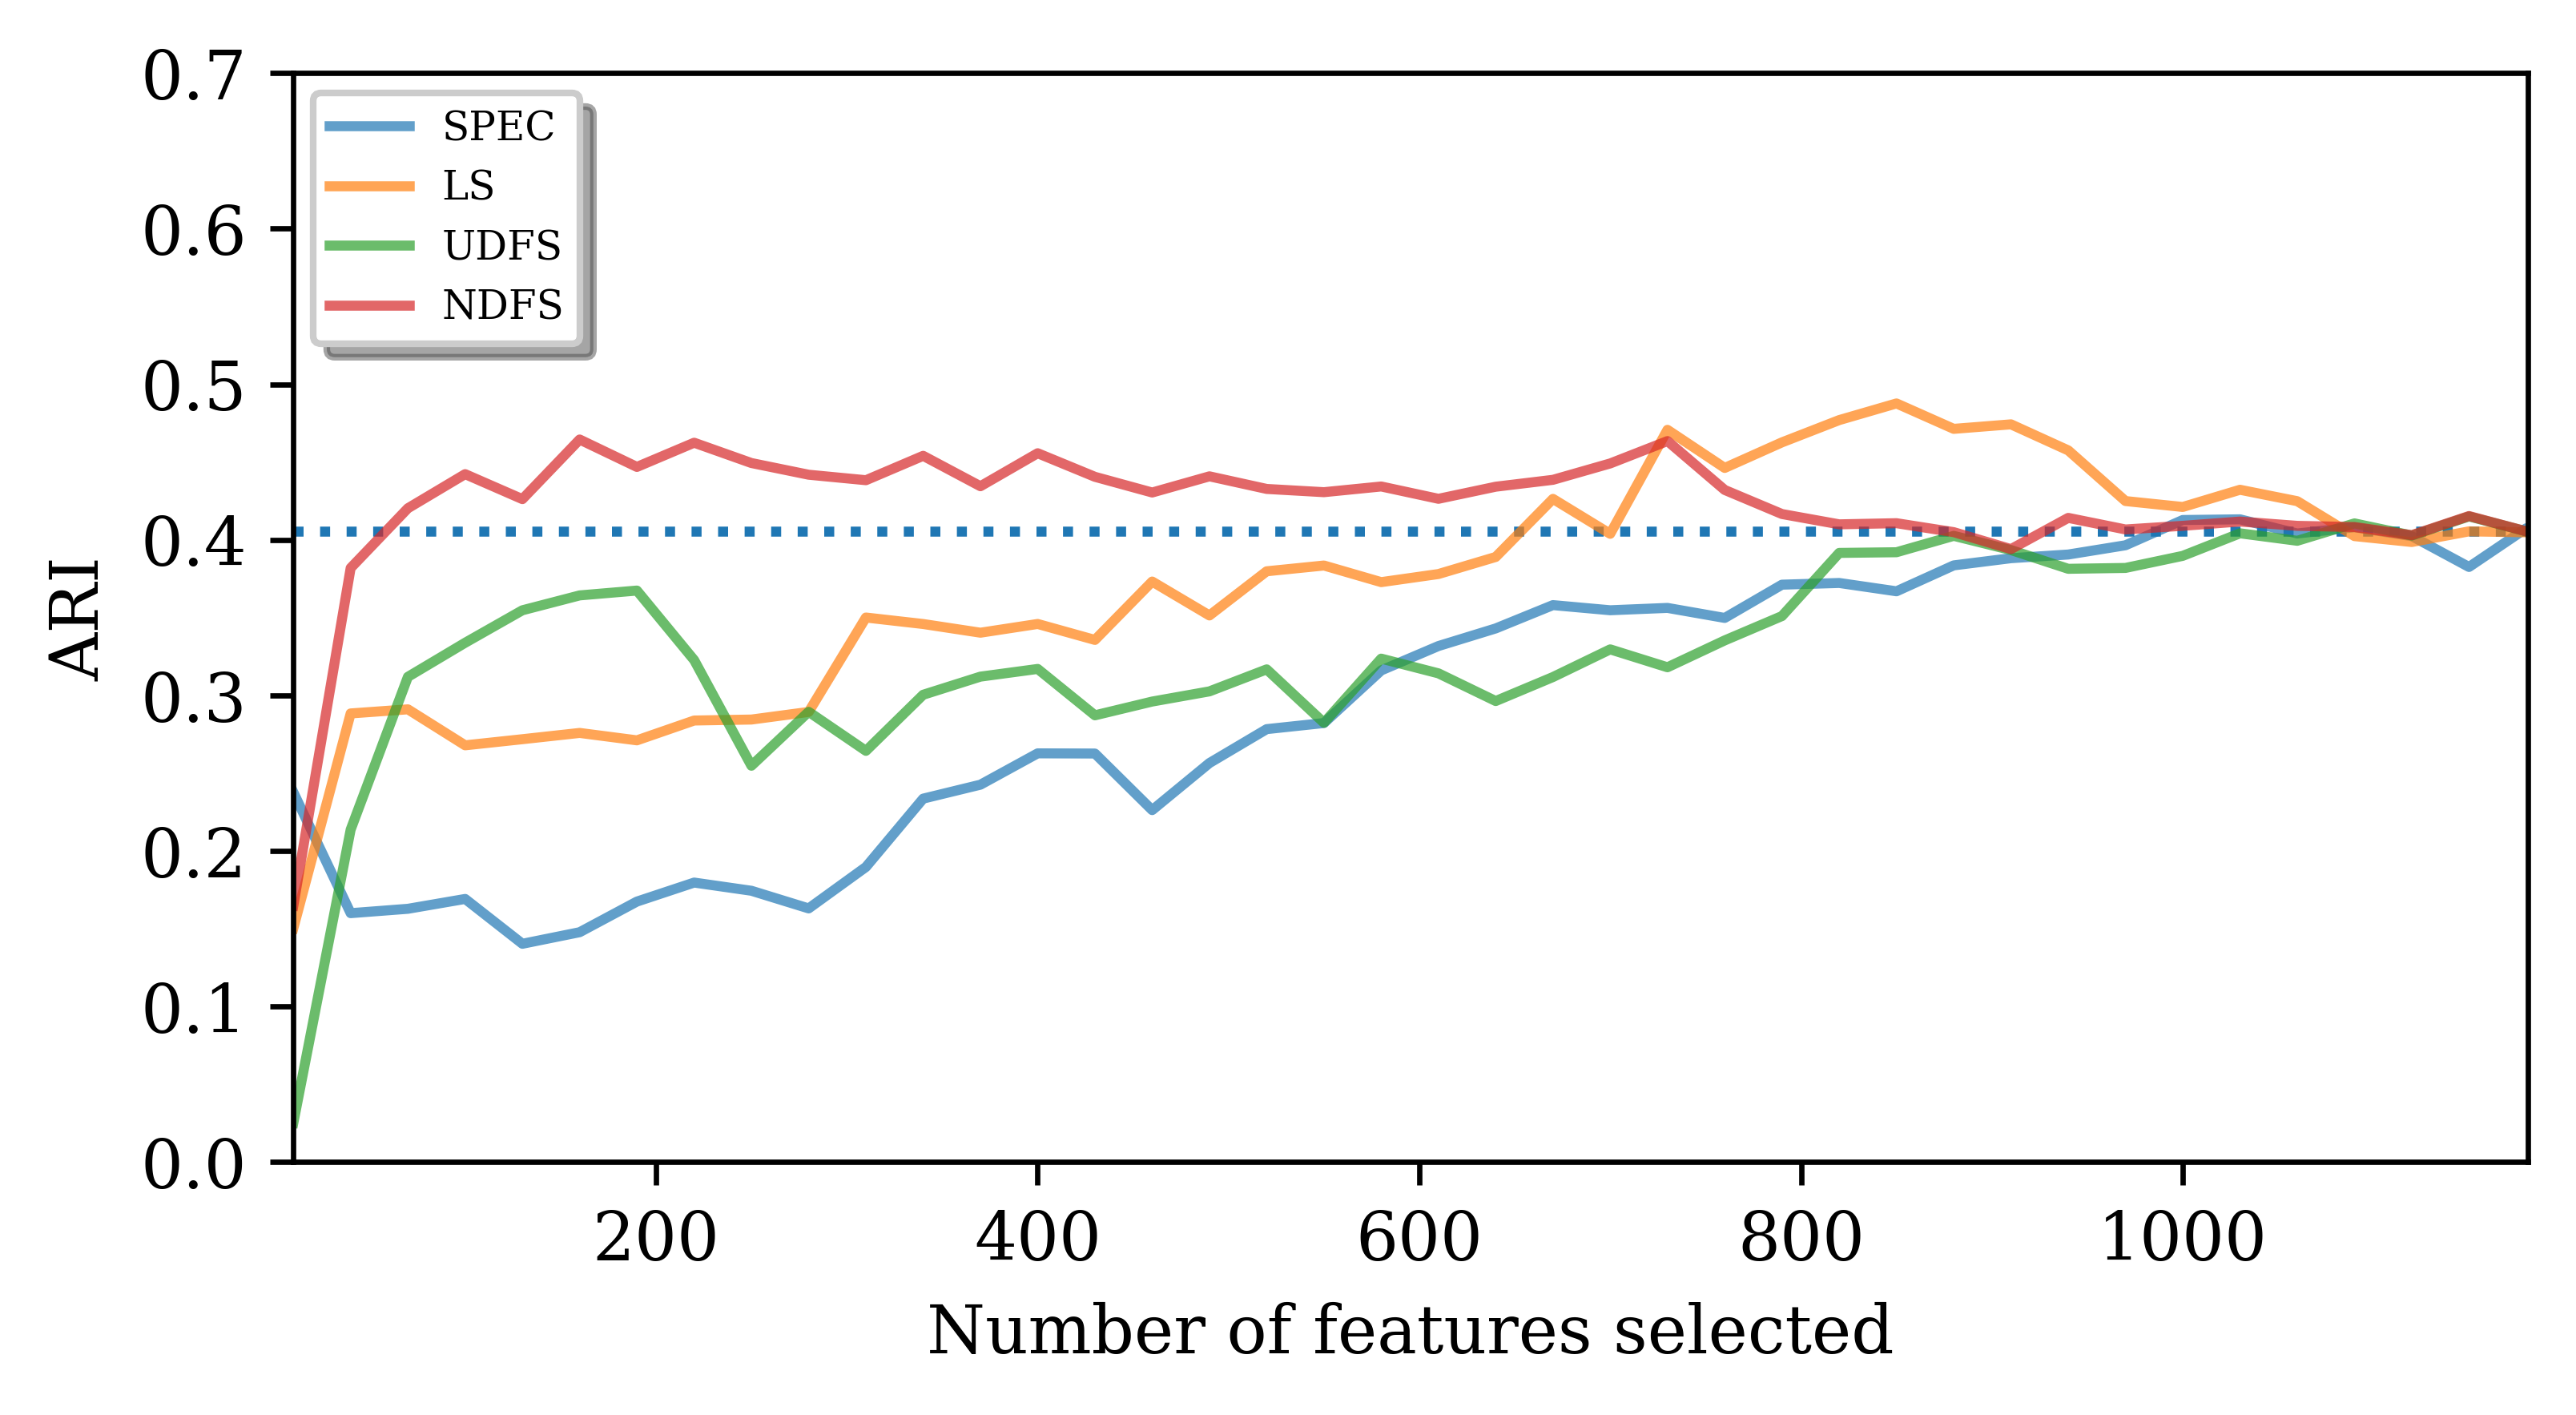

In [52]:
fig, ax = plt.subplots(figsize=(6,3), dpi=600)
plt.rc('font', family='serif', size = 10)
ax.set_xlabel('Number of features selected')
ax.set_ylabel('ARI')
ax.set_ylim(0,0.7)
ax.set_xlim(min(df_result.num_feat),max(df_result.num_feat))
ax.plot(df_result.num_feat,df_result.SPEC_ARI, label = "SPEC", alpha=0.7)
ax.plot(df_result.num_feat,df_result.Lap_ARI, label = "LS", alpha=0.7)
ax.plot(df_result.num_feat,df_result.UDFS_ARI, label = "UDFS", alpha=0.7)
ax.plot(df_result.num_feat,df_result.NDFS_ARI, label = "NDFS", alpha=0.7)
ax.hlines(0.405463, min(df_result.num_feat),max(df_result.num_feat), linestyles="dotted")

plt.legend()
legend = plt.legend(loc='upper left', shadow=True, fontsize=6)
plt.show()
fig.savefig(path+"Clustering ARI comparison Spearman, SMOTE.png", bbox_inches='tight')

### Comparative plot of ARI

In [19]:
Pearson = pd.read_csv(path+"Clustering ARI comparison Pearson, SMOTE.csv")
Pearson_SMOTE = pd.read_csv(path+"Clustering ARI comparison Pearson, without SMOTE.csv")
Spearman = pd.read_csv(path+"Clustering ARI comparison Spearman, SMOTE.csv")
Spearman_SMOTE = pd.read_csv(path+"Clustering ARI comparison Spearman, without SMOTE.csv")

In [36]:
y_SPEC1 = Pearson.SPEC_ARI

In [42]:
y_SPEC1[len(y_SPEC1)-1]

0.4501282284804146

In [69]:
def comparative_plot(file1, file2):
    x1 = file1.num_feat
    x2 = file2.num_feat
    
    y_SPEC1 = file1.SPEC_ARI
    y_SPEC2 = file2.SPEC_ARI
    y_LS1 = file1.Lap_ARI
    y_LS2 = file2.Lap_ARI
    y_UDFS1 = file1.UDFS_ARI
    y_UDFS2 = file2.UDFS_ARI
    y_NDFS1 = file1.NDFS_ARI
    y_NDFS2 = file2.NDFS_ARI
    
    fig, ax = plt.subplots(figsize=(6,3), dpi=600)
    plt.rc('font', family='serif', size = 6)
    ax.set_xlabel('Number of features selected')
    ax.set_ylabel('ARI')
    ax.set_ylim(0,0.7)
    ax.set_xlim(10,1181)
    ax.plot(x1,y_SPEC1, color = "cornflowerblue",label = "SPEC", alpha=1.0)
    ax.plot(x2,y_SPEC2, color = "cornflowerblue",linestyle="--", label = "SPEC_SMOTE", alpha=1.0)
    ax.plot(x1,y_LS1, color = "darkorange",label = "LS", alpha=1.0)
    ax.plot(x2,y_LS2, color = "darkorange",linestyle="--", label = "LS_SMOTE", alpha=1.0)
    ax.plot(x1,y_UDFS1, color = "mediumseagreen",label = "UDFS", alpha=1.0)
    ax.plot(x2,y_UDFS2, color = "mediumseagreen",linestyle="--", label = "UDFS_SMOTE", alpha=1.0)
    ax.plot(x1,y_NDFS1, color = "indianred",label = "NDFS", alpha=1.0)
    ax.plot(x2,y_NDFS2, color = "indianred",linestyle="--", label = "NDFS_SMOTE", alpha=1.0)
    ax.hlines(y_SPEC1[len(y_SPEC1)-1], 10,1181, linestyles="dotted")
    plt.legend()
    legend = plt.legend(loc='upper left', shadow=True, fontsize=6, ncol=4)
    plt.show()
    
    return fig

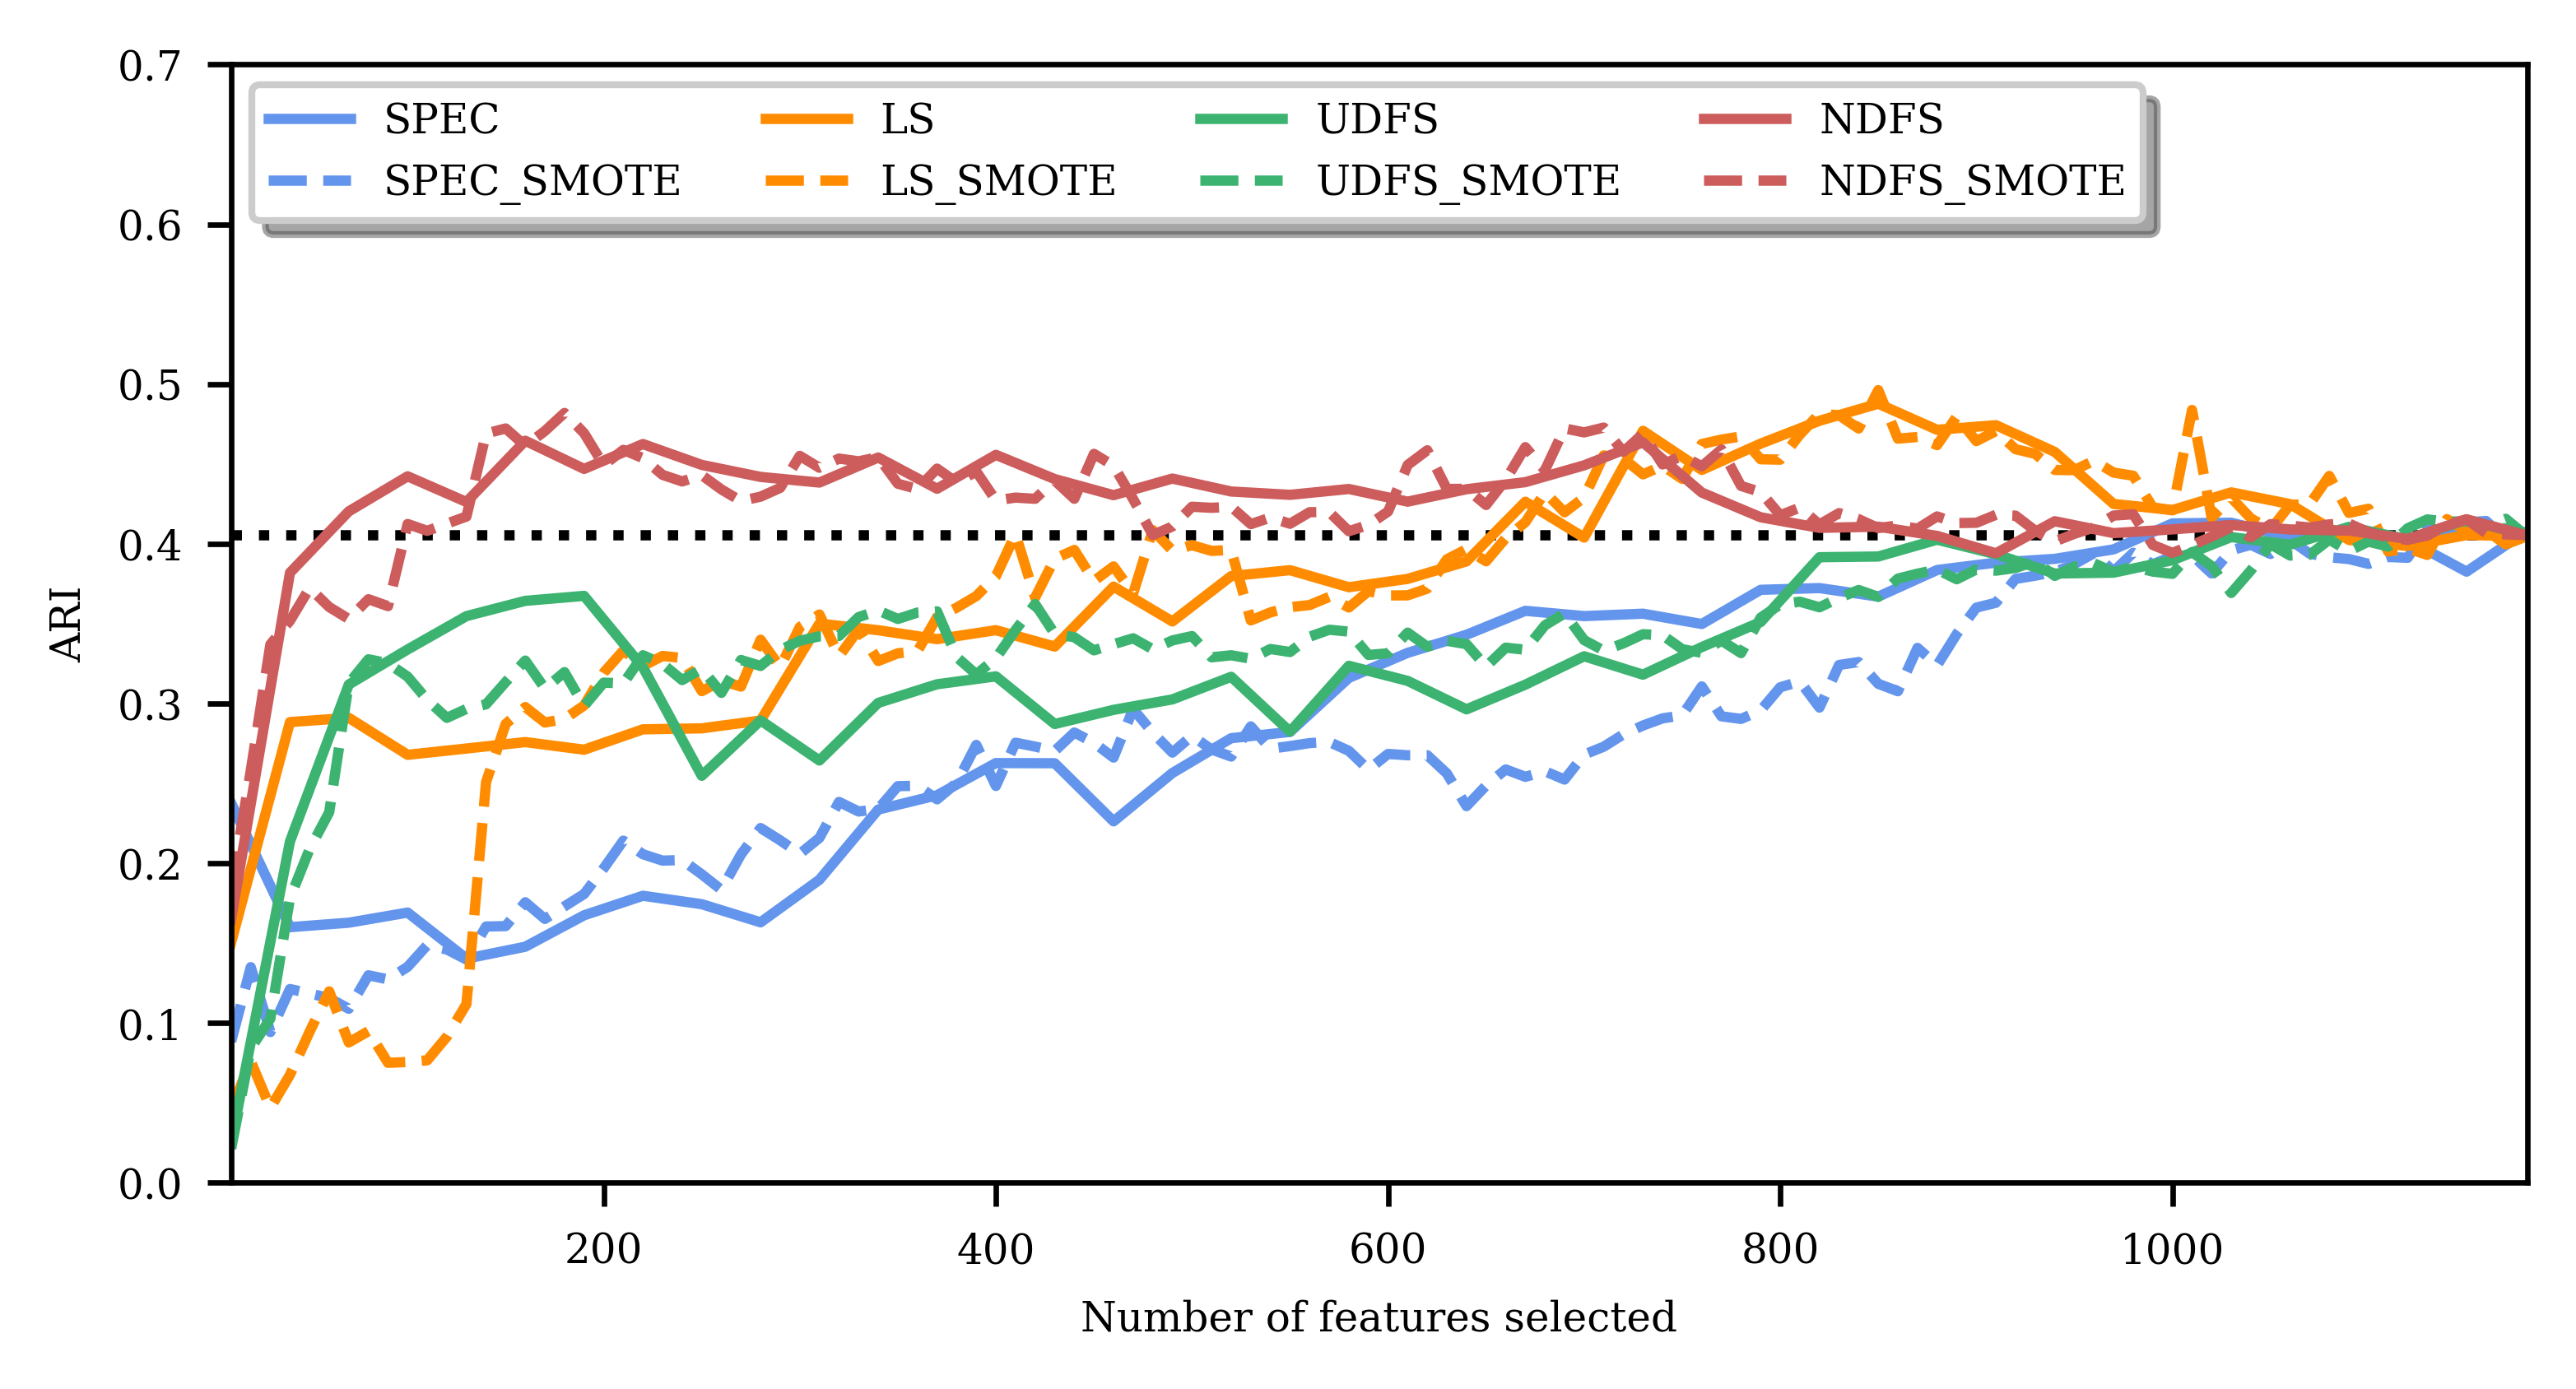

In [71]:
fig = comparative_plot(Spearman, Spearman_SMOTE)
fig.savefig(path+"Figure 8. Clustering ARI Spearman.png", bbox_inches='tight')

### Bar plot style

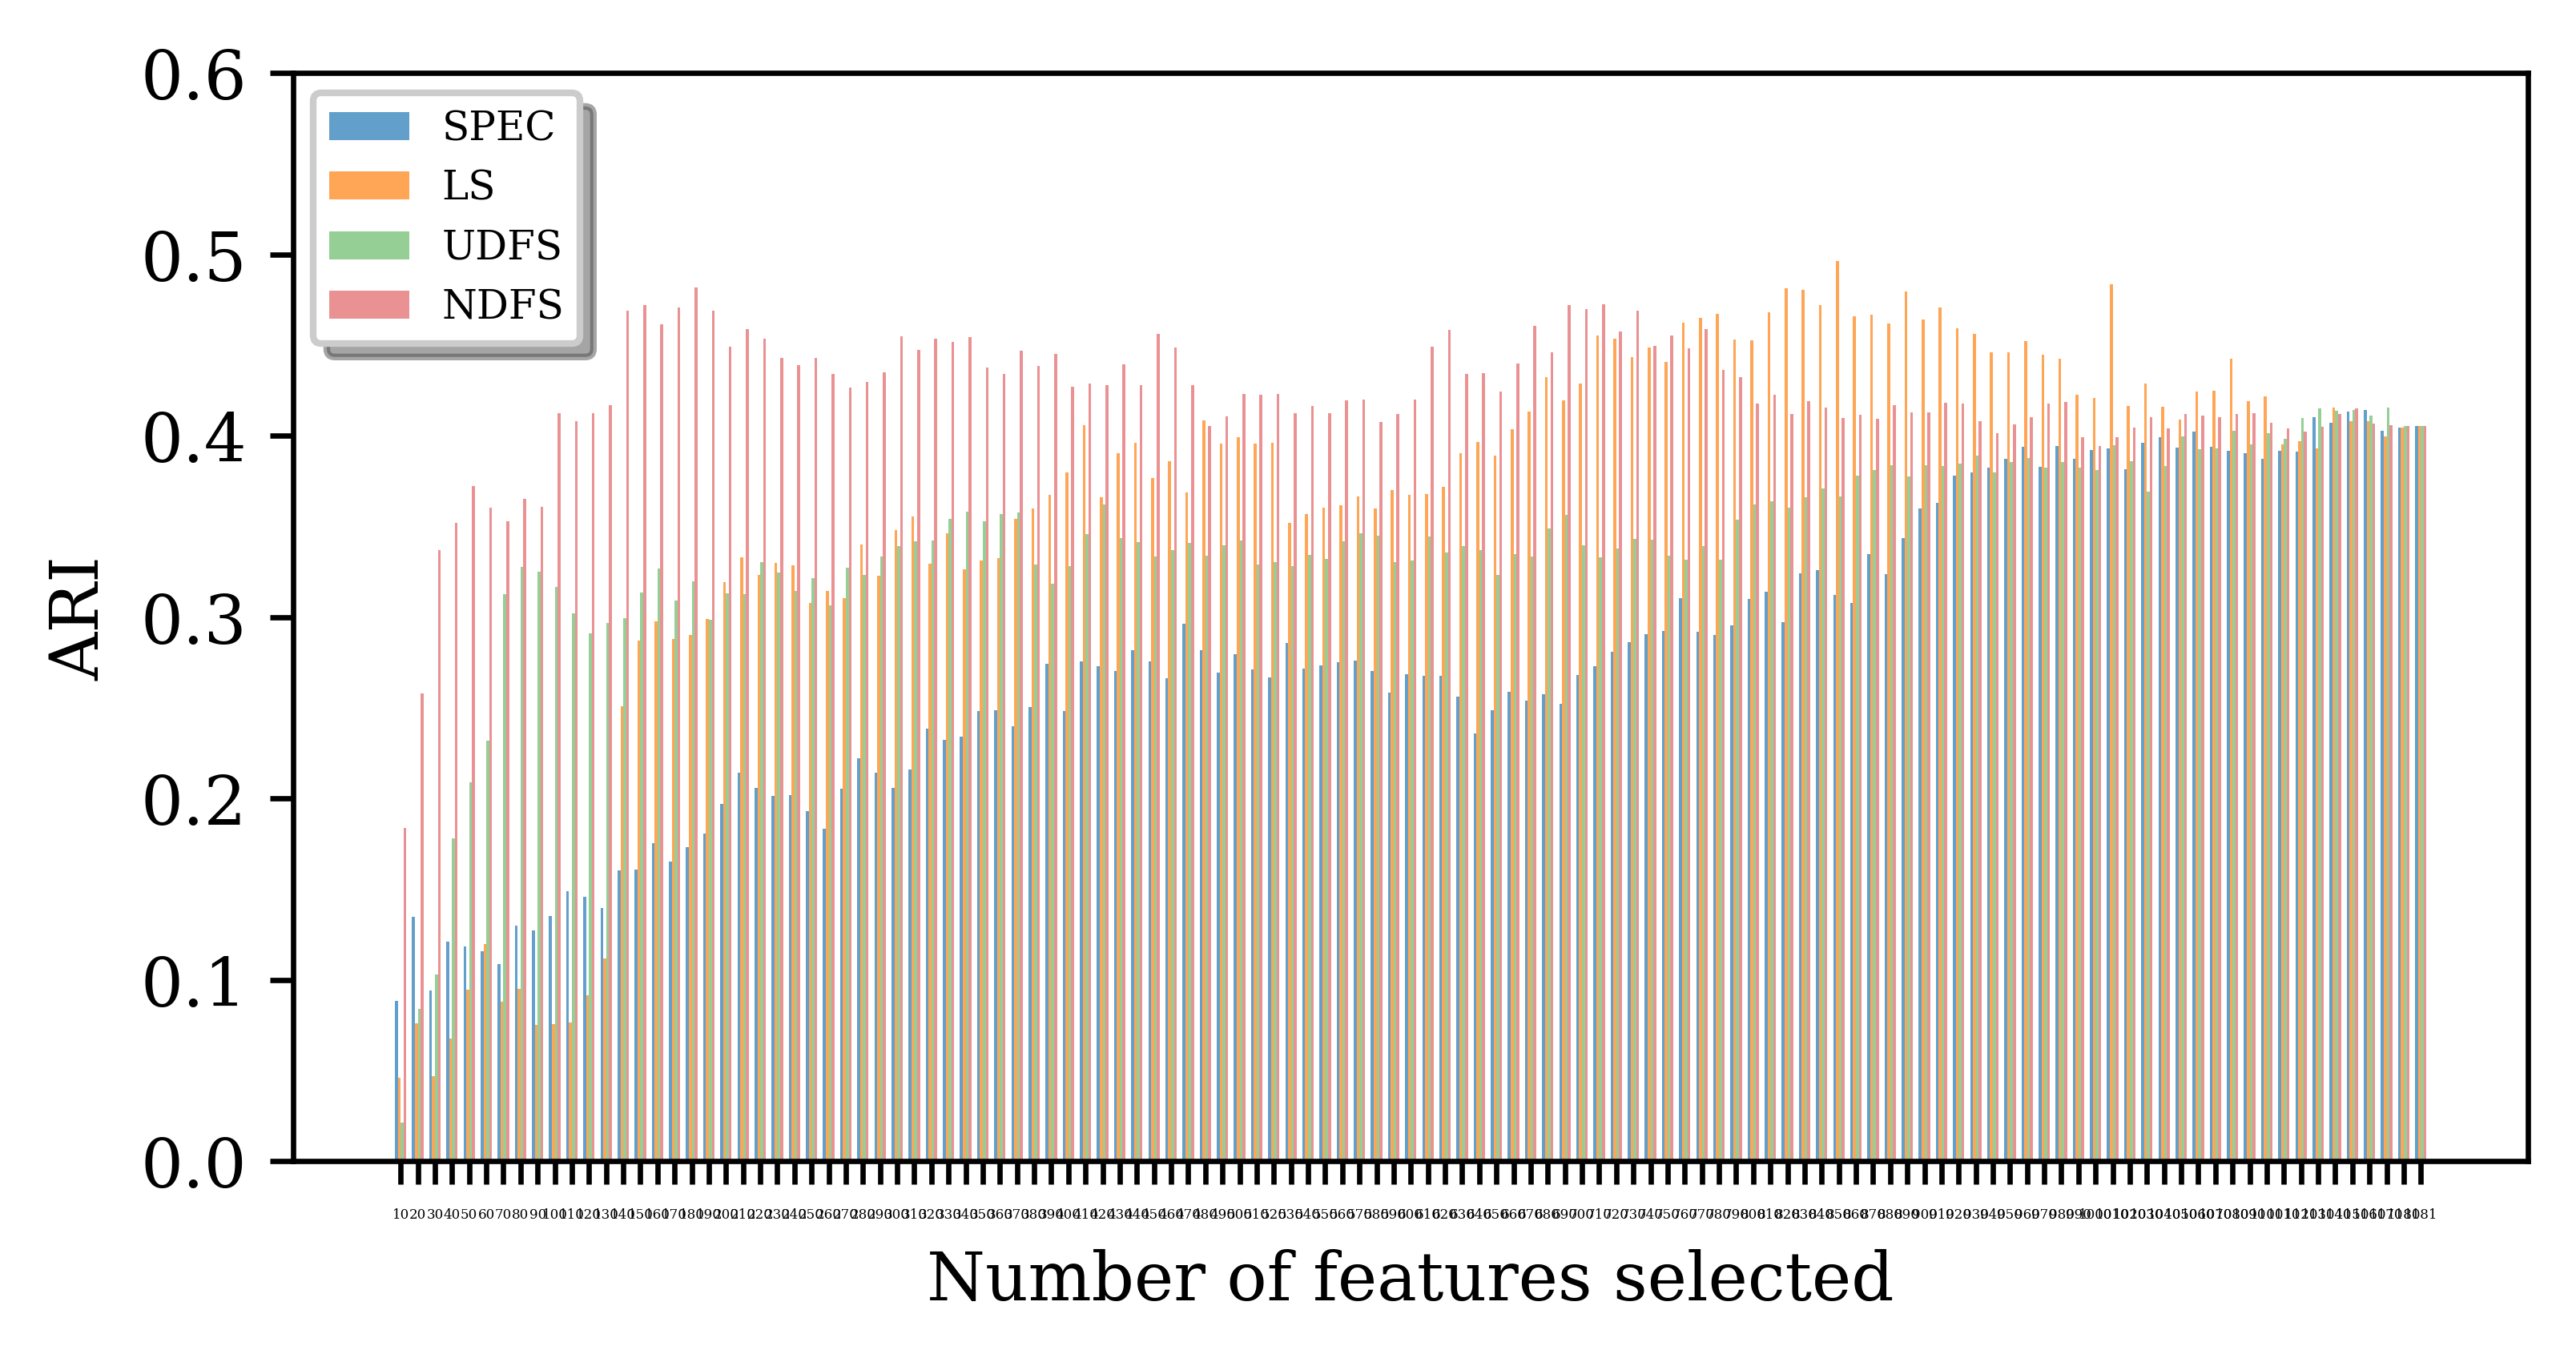

In [32]:
fig, ax = plt.subplots(figsize=(6,3), dpi=600)
plt.rc('font', family='serif', size = 10)
ax.set_xlabel('Number of features selected')
ax.set_ylabel('ARI')
ax.set_xticks(X)
ax.set_xticklabels(labels, fontsize=2)

ax.set_ylim(0,0.6)
ax1 = ax.bar(X-3*width/2,df_result.SPEC_ARI, label = "SPEC", alpha=0.7,width=width)
ax2 = ax.bar(X-width/2,df_result.Lap_ARI, label = "LS", alpha=0.7,width=width)
ax1 = ax.bar(X+width/2,df_result.UDFS_ARI, label = "UDFS", alpha=0.5,width=width)
ax2 = ax.bar(X+3*width/2,df_result.NDFS_ARI, label = "NDFS", alpha=0.5,width=width)

plt.legend()
legend = plt.legend(loc='upper left', shadow=True, fontsize=6)
plt.show()
#fig.savefig(path+"Clustering ARI comparison Spearman, SMOTE.png", bbox_inches='tight')

## Maximal ARI from subset features selected by different selectors

In [56]:
Pearson = pd.read_csv(path+"Clustering ARI comparison Pearson, without SMOTE.csv")
Pearson_SMOTE = pd.read_csv(path+"Clustering ARI comparison Pearson, SMOTE.csv")
Spearman = pd.read_csv(path+"Clustering ARI comparison Spearman, without SMOTE.csv")
Spearman_SMOTE = pd.read_csv(path+"Clustering ARI comparison Spearman, SMOTE.csv")

In [83]:
names = ['Pearson', 'Spearman', 'Pearson_SMOTE', 'Spearman_SMOTE']
dfs = [Pearson, Spearman, Pearson_SMOTE, Spearman_SMOTE]
methods = Pearson.columns[1:5]

In [73]:
def get_Maximal_ARI(df,method):
    df_tmp = df[df[method]==max(df[method])]
    print("Number of features selected:", df_tmp['num_feat'])
    print("Maximal ARI:", df_tmp[method])

In [75]:
get_Maximal_ARI(Pearson,'SPEC_ARI')

Number of features selected: 34    1030
Name: num_feat, dtype: int64
Maximal ARI: 34    0.490122
Name: SPEC_ARI, dtype: float64


In [87]:
for i in range(len(names)):
    print(names[i])
    for method in methods:
        print(method)
        get_Maximal_ARI(dfs[i],method)

Pearson
SPEC_ARI
Number of features selected: 34    1030
Name: num_feat, dtype: int64
Maximal ARI: 34    0.490122
Name: SPEC_ARI, dtype: float64
Lap_ARI
Number of features selected: 33    1000
Name: num_feat, dtype: int64
Maximal ARI: 33    0.484899
Name: Lap_ARI, dtype: float64
UDFS_ARI
Number of features selected: 30    910
Name: num_feat, dtype: int64
Maximal ARI: 30    0.487038
Name: UDFS_ARI, dtype: float64
NDFS_ARI
Number of features selected: 24    730
Name: num_feat, dtype: int64
Maximal ARI: 24    0.480942
Name: NDFS_ARI, dtype: float64
Spearman
SPEC_ARI
Number of features selected: 115    1160
Name: num_feat, dtype: int64
Maximal ARI: 115    0.414264
Name: SPEC_ARI, dtype: float64
Lap_ARI
Number of features selected: 84    850
Name: num_feat, dtype: int64
Maximal ARI: 84    0.496211
Name: Lap_ARI, dtype: float64
UDFS_ARI
Number of features selected: 116    1170
Name: num_feat, dtype: int64
Maximal ARI: 116    0.415667
Name: UDFS_ARI, dtype: float64
NDFS_ARI
Number of features

In [8]:
from sklearn.utils import resample
import time as time
from scipy.stats import ttest_ind

### Evaluate four ensembles of feature subsets, and calculate confidence interval of model performance
* ARI
* AMI

Dataset:

In [6]:
LS = Lap_sorted[0:850]
LS_SMOTE = Lap_SMOTE_sorted[0:840]
NDFS = NDFS_sorted[0:180]
NDFS_SMOTE = NDFS_SMOTE_sorted[0:180]

In [13]:
ensemble1 = set(LS).intersection(NDFS)
print(len(ensemble1))
ensemble2 = set(LS_SMOTE).intersection(set(NDFS_SMOTE))
print(len(ensemble2))
ensemble3 = set(ensemble1).intersection(ensemble2)
print(len(ensemble3))

Lap_union = Union(LS, LS_SMOTE)
NDFS_union = Union(NDFS, NDFS_SMOTE)
ensemble4 = set(Lap_union).intersection(set(NDFS_union))
print(len(ensemble4))

166
175
120
228


In [17]:
# For comparison to ensemble2, union and symmetric difference combination of feature subsets
ensemble5 = Union(LS_SMOTE, NDFS_SMOTE)
print(len(ensemble5))

ensemble6 = set(LS_SMOTE).symmetric_difference(set(NDFS_SMOTE))
print(len(ensemble6))

845
670


In [18]:
def ensemble_evaluation(n_iterations, ensemble):
    n_size = int(len(Y)*0.15)
    n_iterations = n_iterations
    tinit=time.time()
    ARI_stats = list()
    AMI_stats = list()
    for i in range(n_iterations):
        # Prepare subsets
        X_test, Y_test = resample(X, Y, n_samples = n_size)
        # Subset using ensemble feature list
        X_select = X_test[ensemble]
        # Baseline using all features
        #X_select = X_test
        
        # Calculate correlation coefficient matrix
        M = Spearman_matrix(X_select,0)
        Z = linkage(M.values, method='ward')
        cluster_nodes = fcluster(Z,16, criterion='maxclust')
        ARI = adjusted_rand_score(Y_test,cluster_nodes)
        AMI = adjusted_mutual_info_score(Y_test, cluster_nodes)
        print(ARI)
        print(AMI)
        ARI_stats.append(ARI)
        AMI_stats.append(AMI)
    tfinal=time.time()
    print('Done!')
    print('Time required for boostrap evaluation:', tfinal-tinit, 'seconds')
    
    # plot scores
    plt.hist(ARI_stats)
    plt.hist(AMI_stats)
    plt.show()
    
    # Confidence intervals
    alpha = 0.95
    # Lower
    p = ((1.0-alpha)/2.0) * 100  
    ARI_lower = max(0.0, np.percentile(ARI_stats, p))
    AMI_lower = max(0.0, np.percentile(AMI_stats, p))
    # Upper
    p = (alpha+((1.0-alpha)/2.0)) * 100
    ARI_upper = min(1.0, np.percentile(ARI_stats, p))
    AMI_upper = min(1.0, np.percentile(AMI_stats, p))
    print('%.1f confidence interval of ARI %.3f and %.3f' % (alpha*100, ARI_lower, ARI_upper))
    print('%.1f confidence interval of AMI %.3f and %.3f' % (alpha*100, AMI_lower, AMI_upper))
    print('Average ARI %.3f and Average AMI %.3f' % (np.mean(ARI_stats), np.mean(AMI_stats)))
    return ARI_stats, AMI_stats

In [28]:
df_ensemble = pd.read_csv(path+"Ensemble feature subset clustering results - ARI and AMI.csv")

In [457]:
#base_ARI, base_AMI = ensemble_evaluation(250)
df_ensemble['base_ARI'] = base_ARI
df_ensemble['base_AMI'] = base_AMI

In [459]:
#ensemble1_ARI, ensemble1_AMI = ensemble_evaluation(250, ensemble1)
df_ensemble['ensemble1_ARI'] = ensemble1_ARI
df_ensemble['ensemble1_AMI'] = ensemble1_AMI

In [460]:
#ensemble2_ARI, ensemble2_AMI = ensemble_evaluation(250, ensemble2)
df_ensemble['ensemble2_ARI'] = ensemble2_ARI
df_ensemble['ensemble2_AMI'] = ensemble2_AMI

In [461]:
#ensemble3_ARI, ensemble3_AMI = ensemble_evaluation(250, ensemble3)
df_ensemble['ensemble3_ARI'] = ensemble3_ARI
df_ensemble['ensemble3_AMI'] = ensemble3_AMI

In [462]:
#ensemble4_ARI, ensemble4_AMI = ensemble_evaluation(250, ensemble4)
df_ensemble['ensemble4_ARI'] = ensemble4_ARI
df_ensemble['ensemble4_AMI'] = ensemble4_AMI

0.4809398527215007
0.6258978754754755
0.4710963606280559
0.6334269515140238
0.5032385633704446
0.654145954679955
0.43014573778515913
0.6186108504547779
0.4883640055151155
0.6406423393922717
0.4649663571623809
0.6304940998512548
0.5092170447809918
0.6442630410510335
0.5787816564543813
0.7021729343241416
0.39031070867179335
0.5778125146112157
0.4388699904498927
0.6044411572479348
0.44915676745816896
0.5931558806639109
0.4754875496116703
0.630225604855503
0.3750959963279668
0.5585903483903527
0.48067243887613625
0.6382267597225977
0.5353547791810856
0.696342023429432
0.4537625466970061
0.5971455603111296
0.4945467729542892
0.6193154451160947
0.5707458767913184
0.7011051796204953
0.4091193637110899
0.5880262282614062
0.3709681227553315
0.5686166490803889
0.4680730064699284
0.6286791367529089
0.41746530991397723
0.6055160388762971
0.6386943492157346
0.7500361803164921
0.4602324910822081
0.6113885388455218
0.4469076833889228
0.6107483185350544
0.43743386958797087
0.5998702043309587
0.5920408

0.4946374287867891
0.6443543625665752
0.5513231815151455
0.6383915780325384
0.4377479286690368
0.6119052150974904
0.4224859728691389
0.587988605192101
0.5182464112087357
0.6215806005713493
0.41839796279038644
0.5697181541278405
0.39920641004167784
0.5683604229887652
0.5308662936842846
0.628605060580922
0.4471190062000888
0.602011295443151
0.5833339043905421
0.6946308610705988
0.5066566494975596
0.6371627957847023
0.47625167123575896
0.6031025476067983
0.5234405596203352
0.6258393701559274
0.40085975862284373
0.587192470821657
0.4662501911156849
0.6415651477487511
0.3858556091705528
0.5464246692178375
0.3871385437759312
0.5607631281104049
0.48089427627725645
0.6065918938168677
0.3634832013261389
0.5412395536111373
0.4065530383051442
0.6074254349662186
0.5356755498888953
0.6997915587975704
0.4377755825549445
0.5886761929519122
0.4581991992977066
0.6313608381244025
0.3912817177071715
0.6018991549636014
0.44536388056936427
0.5948189224084678
0.6146786995641623
0.7060740383858088
0.53250677

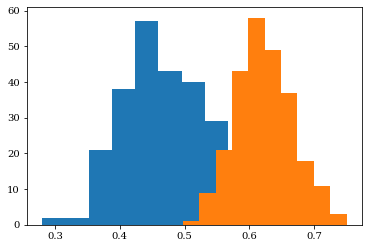

95.0 confidence interval of ARI 0.362 and 0.600
95.0 confidence interval of AMI 0.546 and 0.710
Average ARI 0.470 and Average AMI 0.623


In [464]:
#LS_ARI, LS_AMI = ensemble_evaluation(250, LS)
df_ensemble['LS_ARI'] = LS_ARI
df_ensemble['LS_AMI'] = LS_AMI

0.49124815215031054
0.629310768309952
0.44144962456264
0.5935544174914905
0.46406910712009375
0.6279546149032683
0.47178255706132227
0.6176310480889148
0.5096012836149423
0.6353620423956424
0.38479748040390055
0.5971536486880724
0.457884970817564
0.6304464128632022
0.44237942153009013
0.625854679056991
0.4548355271200843
0.6240093914966836
0.5997435556782431
0.6745311009022978
0.47983360490369426
0.6383215142262613
0.48664290162113644
0.6368950810493109
0.48465856615513064
0.639909234726912
0.40900135905350876
0.5898734362116711
0.4931877643130159
0.655081651855256
0.41280310348237925
0.5624976824464413
0.4766173098621198
0.6324897883806788
0.5243133487626594
0.6826699432938277
0.4013717919564156
0.5649660234260636
0.45815356977426447
0.6177494029193883
0.4358922250601871
0.584032222090296
0.45918321074541313
0.6081712342474537
0.49288105602336946
0.6407035837881504
0.4909855764861689
0.6101434681107224
0.45690157223404787
0.6364526270250509
0.4375735025219159
0.6122525897452018
0.5713

0.42863081921972057
0.5990443995071775
0.602343211066136
0.7035766639621411
0.4823968548163627
0.6319234452149851
0.533600764804019
0.6516813545483474
0.6114940316302052
0.7083695048433651
0.46389241456256336
0.6379374622747845
0.38639060772435196
0.5544980023671893
0.4253609349312894
0.5915818326710132
0.5227153001530556
0.6711519175547341
0.5604320363539398
0.678237600106569
0.37365511303250015
0.5596537208581491
0.4504372501015831
0.6248668291850337
0.36715284463599634
0.609568088855575
0.5027394195757022
0.6292496271429234
0.404530409459071
0.5701674952155217
0.42375746692441446
0.6291988697120854
0.4490508164779418
0.6206056555462619
0.4951429432255898
0.6162661306753412
0.4258146641359708
0.5840533879075092
0.5111595879693577
0.6608090467847247
0.4428466721348429
0.617534488102107
0.46436030003206097
0.6280781760356681
0.3750573267364402
0.552140944049428
0.42579918207452483
0.5942231546640352
0.4836028502335198
0.6560815737800999
0.3906307247206863
0.5837778221275304
0.505246764

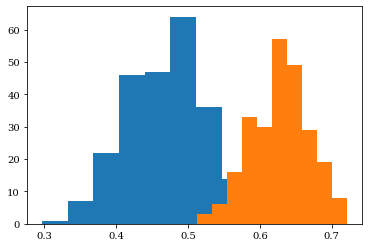

95.0 confidence interval of ARI 0.365 and 0.598
95.0 confidence interval of AMI 0.550 and 0.703
Average ARI 0.474 and Average AMI 0.628


In [465]:
#LS_SMOTE_ARI, LS_SMOTE_AMI = ensemble_evaluation(250, LS_SMOTE)
df_ensemble['LS_SMOTE_ARI'] = LS_SMOTE_ARI
df_ensemble['LS_SMOTE_AMI'] = LS_SMOTE_AMI

0.45811497831885695
0.6325636122267831
0.4227843011793134
0.6086692652291469
0.46050446490447944
0.647174685973875
0.4839176499862488
0.6352763469211422
0.39999884506887723
0.6109493640333994
0.3870025348345842
0.5692203171570707
0.4407091374092813
0.5800043381072035
0.37621810542179357
0.5616604292018199
0.5311375383861928
0.6678712920561192
0.5142879865595006
0.6693501737105645
0.3656905011068476
0.5629744320047577
0.4864152396328024
0.6053085821820212
0.37287305508037605
0.5792840412216772
0.43207844957072816
0.588235698853548
0.4243030294597635
0.6290332228573728
0.5919775093922839
0.6713892136752305
0.5623756225950555
0.6542873439241231
0.5187220600126977
0.6175686162793145
0.4417111075960684
0.6012882119881297
0.42453568580925105
0.5859406499367816
0.5307237325586591
0.6622021026861112
0.5323121468981653
0.6515636408050924
0.4182776572809188
0.6128976295140509
0.4307360509855371
0.6276911474505769
0.46168713252065663
0.5931951302814592
0.4581838857904321
0.6589264231971164
0.4886

0.4666470112817587
0.6356061870510415
0.4276519614664116
0.5982655244848879
0.5082206361378928
0.6667398211675047
0.514648445026433
0.6526484579429525
0.49899625468164793
0.6673014036405155
0.4733913502833683
0.6273979403742126
0.5400067051263183
0.6698428783163998
0.5189287747742862
0.645684863051409
0.3942718591044283
0.593402442431292
0.43707504460305524
0.5736953506675125
0.4301303054040486
0.6082176060858359
0.5259457113681095
0.64820368418346
0.43450351091599554
0.6162451922553144
0.45851455604092106
0.6219863280357191
0.4586066525757846
0.6010582611396118
0.3948280267844842
0.5705646245187441
0.3905596465517316
0.5937396882908779
0.41733089508423965
0.5855422134398448
0.4356783824746795
0.6155769513912499
0.4490237504557006
0.6064231949267767
0.5156741180099819
0.6328244654761506
0.41277016315497456
0.615219643489914
0.3373527521025691
0.5432282193406148
0.4822075031161488
0.6767859982182971
0.5295666015200186
0.6369624568045064
0.385168798627028
0.593275444760061
0.441917341071

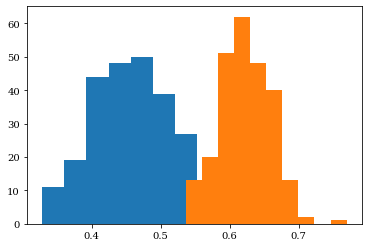

95.0 confidence interval of ARI 0.348 and 0.584
95.0 confidence interval of AMI 0.551 and 0.691
Average ARI 0.460 and Average AMI 0.623


In [466]:
#NDFS_ARI, NDFS_AMI = ensemble_evaluation(250, NDFS)
df_ensemble['NDFS_ARI'] = NDFS_ARI
df_ensemble['NDFS_AMI'] = NDFS_AMI

0.5032488409212619
0.6377396254153441
0.4455286773346346
0.6403072846859783
0.41037753539913924
0.5872708174298095
0.5647633166387587
0.6881156428626201
0.4895602705329874
0.6280429900365124
0.5777121905010606
0.7017570904749579
0.5447258671549181
0.7095361718511991
0.5920150869199429
0.7261740085607339
0.43752167824981053
0.5980521914090782
0.46590372327118695
0.6478128546134502
0.5355282059105017
0.6740388948563879
0.49655760523025144
0.635910190669688
0.3508318716494715
0.5484238695240199
0.3083920797993572
0.5485231689353811
0.3931809651739328
0.5922578953362444
0.4026149022664706
0.6036870459330356
0.47466204699963466
0.6229121074434897
0.417985559470635
0.5845301065923009
0.4632926556295234
0.6415184086159466
0.4297972179896344
0.6134605995357556
0.47964326968550547
0.6141351987866659
0.44797152095221227
0.6389948023647894
0.4958314085458998
0.6549596644166491
0.4035094084052577
0.5855720164365611
0.39713952779967027
0.6160022345594213
0.5025805910722875
0.6550520087771012
0.4007

0.4390946570904129
0.6227280907638961
0.4941495716014905
0.6339141652735389
0.4779386365157855
0.624656217820412
0.46971684655912327
0.6442477000082844
0.3383103599900587
0.5491516906286366
0.4608690341411479
0.6505563158721535
0.4020438005849146
0.6063387393021855
0.4913498519280533
0.6418863912449606
0.5101648352224174
0.6773298510676404
0.36869495978979216
0.5499202463884317
0.4612996034427125
0.6059765397488764
0.38596516348317766
0.5881001998765295
0.5287874679259327
0.6112632034287351
0.45679729629833216
0.6448365662442708
0.44026307226361266
0.6319290946136419
0.45580441224193935
0.6220271918793948
0.41169651679114355
0.6180093239125575
0.572305566423794
0.6827275973490309
0.4788442096793941
0.6400618870522865
0.44872056848173963
0.6282594101435025
0.4073025038911219
0.628673742437162
0.5314685144820751
0.6369572386991291
0.512908358305369
0.6601723711336797
0.3719625719842264
0.5860024823178313
0.43495425474497995
0.6013457404585758
0.5196254039008016
0.6533452159197296
0.42287

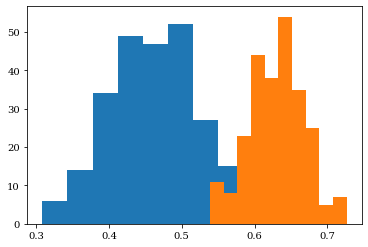

95.0 confidence interval of ARI 0.346 and 0.582
95.0 confidence interval of AMI 0.549 and 0.708
Average ARI 0.463 and Average AMI 0.630


In [467]:
#NDFS_SMOTE_ARI, NDFS_SMOTE_AMI = ensemble_evaluation(250, NDFS_SMOTE)
df_ensemble['NDFS_SMOTE_ARI'] = NDFS_SMOTE_ARI
df_ensemble['NDFS_SMOTE_AMI'] = NDFS_SMOTE_AMI

0.3830673253336061
0.581880680385362
0.43686698176907496
0.6199443620134913
0.46846668067085256
0.6385190718179331
0.4472146552116574
0.6064173821915312
0.47655404893584924
0.6138505690248849
0.4553838129420641
0.6099520577354444
0.39359327926457616
0.5701772835982777
0.5979207810451362
0.6930976858380938
0.4451816266028503
0.617309060728062
0.5403880387936544
0.6743976356628811
0.4749045458943083
0.6148848961508097
0.4900204968789754
0.6226836314571434
0.5182718302669417
0.6629718546155051
0.453006319264273
0.5843633940362365
0.4571657437815119
0.6014668118665802
0.3990902375490844
0.5634841628222809
0.41138864091417277
0.5693860353119317
0.44280425566828086
0.5973587242840294
0.37346927378758504
0.5604299533405419
0.4932763077873835
0.6068433313127578
0.4063417405544992
0.5912351362506949
0.3291763243764755
0.5313634387468191
0.5324892453787353
0.6350157911897787
0.5146126027310939
0.6462934784224007
0.49472777102056403
0.6317505401402077
0.3809932527759249
0.5525366190800854
0.48686

0.5213642544796979
0.6678623342021446
0.4122188712913262
0.5511962518575738
0.5211374250353006
0.6264987319237293
0.5660109456781988
0.6809018720721407
0.41848394120229965
0.6244552867104552
0.5481600579714516
0.6392467860186705
0.5270204845091316
0.6361553434368852
0.44763277791640094
0.6083068707861361
0.4527058184220585
0.6184610111597658
0.3869411345489292
0.6007277585337614
0.42475486957112535
0.5883390445043346
0.523650231382411
0.6746609489874453
0.5038305270771695
0.645265641418257
0.3544654689891131
0.592525159580361
0.41098624234186937
0.5710898033121412
0.413508289429047
0.5628325185884451
0.426484450220058
0.5905808977770509
0.4943009927196144
0.6703055086269065
0.4053102457445425
0.5665086116580472
0.5284414010115448
0.6441223623102861
0.4028181662404733
0.5856014684210571
0.4192662440828322
0.5795515383967212
0.4690305343723675
0.5785372370367845
0.42772515750791656
0.5886382589922077
0.42710172439460337
0.5746317577239592
0.39344389009907943
0.5933214693661524
0.46918097

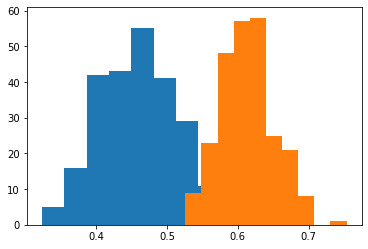

95.0 confidence interval of ARI 0.357 and 0.584
95.0 confidence interval of AMI 0.541 and 0.691
Average ARI 0.461 and Average AMI 0.613


In [29]:
ensemble6_ARI, ensemble6_AMI = ensemble_evaluation(250, ensemble6)
df_ensemble['ensemble6_ARI'] = ensemble6_ARI
df_ensemble['ensemble6_AMI'] = ensemble6_AMI

In [31]:
df_ensemble.to_csv(path+"Ensemble feature subset clustering results - ARI and AMI.csv", index=False)

In [33]:
df_ensemble.head()

,base_ARI,base_AMI,ensemble1_ARI,ensemble1_AMI,ensemble2_ARI,ensemble2_AMI,ensemble3_ARI,ensemble3_AMI,ensemble4_ARI,ensemble4_AMI,LS_ARI,LS_AMI,LS_SMOTE_ARI,LS_SMOTE_AMI,NDFS_ARI,NDFS_AMI,NDFS_SMOTE_ARI,NDFS_SMOTE_AMI,ensemble6_ARI,ensemble6_AMI
0,0.418923,0.593696,0.502723,0.635179,0.484720,0.626386,0.556878,0.692802,0.485455,0.630565,0.480940,0.625898,0.491248,0.629311,0.458115,0.632564,0.503249,0.637740,0.383067,0.581881
1,0.514143,0.684216,0.426493,0.609769,0.414028,0.611443,0.461654,0.630271,0.516393,0.697433,0.471096,0.633427,0.441450,0.593554,0.422784,0.608669,0.445529,0.640307,0.436867,0.619944
2,0.437344,0.618037,0.468212,0.647632,0.484847,0.625655,0.383669,0.571512,0.475023,0.635118,0.503239,0.654146,0.464069,0.627955,0.460504,0.647175,0.410378,0.587271,0.468467,0.638519
3,0.512414,0.613269,0.485578,0.645406,0.396990,0.608975,0.486684,0.634233,0.502869,0.625632,0.430146,0.618611,0.471783,0.617631,0.483918,0.635276,0.564763,0.688116,0.447215,0.606417
4,0.461753,0.590335,0.436775,0.613346,0.435248,0.626431,0.378866,0.553858,0.492694,0.644117,0.488364,0.640642,0.509601,0.635362,0.399999,0.610949,0.489560,0.628043,0.476554,0.613851


Student's t-Test

In [32]:
def compare_score(score1, score2):
    # compare samples
    stat, p = ttest_ind(score1, score2)
    print('Statistics=%.3f, p=%.10f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

In [475]:
print("ensemble 1:")
compare_score(base_ARI, ensemble1_ARI)
print("ensemble 2:")
compare_score(base_ARI, ensemble2_ARI)
print("ensemble 3:")
compare_score(base_ARI, ensemble3_ARI)
print("ensemble 4:")
compare_score(base_ARI, ensemble4_ARI)


ensemble 1:
Statistics=-9.428, p=0.0000000000
Different distributions (reject H0)
ensemble 2:
Statistics=-10.353, p=0.0000000000
Different distributions (reject H0)
ensemble 3:
Statistics=-9.461, p=0.0000000000
Different distributions (reject H0)
ensemble 4:
Statistics=-8.852, p=0.0000000000
Different distributions (reject H0)


In [38]:
print("ensemble 6:")
compare_score(df_ensemble.base_ARI, ensemble6_ARI)
compare_score(df_ensemble.base_AMI, ensemble6_AMI)

ensemble 6:
Statistics=-8.843, p=0.0000000000
Different distributions (reject H0)
Statistics=-7.442, p=0.0000000000
Different distributions (reject H0)


In [37]:
compare_score(df_ensemble.ensemble2_ARI, ensemble6_ARI)
compare_score(df_ensemble.ensemble2_AMI, ensemble6_AMI)

Statistics=2.028, p=0.0430478217
Different distributions (reject H0)
Statistics=6.615, p=0.0000000001
Different distributions (reject H0)


In [476]:
print("LS:")
compare_score(base_ARI, LS_ARI)
print("LS_SMOTE:")
compare_score(base_ARI, LS_SMOTE_ARI)
print("NDFS:")
compare_score(base_ARI, NDFS_ARI)
print("NDFS_SMOTE:")
compare_score(base_ARI, NDFS_SMOTE_ARI)

LS:
Statistics=-9.951, p=0.0000000000
Different distributions (reject H0)
LS_SMOTE:
Statistics=-10.998, p=0.0000000000
Different distributions (reject H0)
NDFS:
Statistics=-8.586, p=0.0000000000
Different distributions (reject H0)
NDFS_SMOTE:
Statistics=-8.866, p=0.0000000000
Different distributions (reject H0)


In [477]:
print("ensemble 1:")
compare_score(base_AMI, ensemble1_AMI)
print("ensemble 2:")
compare_score(base_AMI, ensemble2_AMI)
print("ensemble 3:")
compare_score(base_AMI, ensemble3_AMI)
print("ensemble 4:")
compare_score(base_AMI, ensemble4_AMI)

ensemble 1:
Statistics=-11.021, p=0.0000000000
Different distributions (reject H0)
ensemble 2:
Statistics=-13.512, p=0.0000000000
Different distributions (reject H0)
ensemble 3:
Statistics=-12.147, p=0.0000000000
Different distributions (reject H0)
ensemble 4:
Statistics=-11.129, p=0.0000000000
Different distributions (reject H0)


In [478]:
print("LS:")
compare_score(base_AMI, LS_AMI)
print("LS_SMOTE:")
compare_score(base_AMI, LS_SMOTE_AMI)
print("NDFS:")
compare_score(base_AMI, NDFS_AMI)
print("NDFS_SMOTE:")
compare_score(base_AMI, NDFS_SMOTE_AMI)

LS:
Statistics=-9.504, p=0.0000000000
Different distributions (reject H0)
LS_SMOTE:
Statistics=-11.201, p=0.0000000000
Different distributions (reject H0)
NDFS:
Statistics=-10.281, p=0.0000000000
Different distributions (reject H0)
NDFS_SMOTE:
Statistics=-12.214, p=0.0000000000
Different distributions (reject H0)


In [481]:
compare_score(ensemble2_ARI, LS_ARI)
compare_score(ensemble2_AMI, LS_AMI)
compare_score(ensemble2_ARI, LS_SMOTE_ARI)
compare_score(ensemble2_AMI, LS_SMOTE_AMI)

Statistics=0.390, p=0.6968797012
Same distributions (fail to reject H0)
Statistics=3.583, p=0.0003727783
Different distributions (reject H0)
Statistics=-0.301, p=0.7635266702
Same distributions (fail to reject H0)
Statistics=2.524, p=0.0118993876
Different distributions (reject H0)


In [482]:
compare_score(ensemble2_ARI, NDFS_ARI)
compare_score(ensemble2_AMI, NDFS_AMI)
compare_score(ensemble2_ARI, NDFS_SMOTE_ARI)
compare_score(ensemble2_AMI, NDFS_SMOTE_AMI)

Statistics=2.172, p=0.0302951033
Different distributions (reject H0)
Statistics=4.036, p=0.0000629485
Different distributions (reject H0)
Statistics=1.588, p=0.1129368800
Same distributions (fail to reject H0)
Statistics=1.883, p=0.0603484088
Same distributions (fail to reject H0)


In [483]:
compare_score(LS_SMOTE_ARI, LS_ARI)
compare_score(LS_AMI, LS_SMOTE_AMI)

Statistics=0.702, p=0.4827744337
Same distributions (fail to reject H0)
Statistics=-1.200, p=0.2307390651
Same distributions (fail to reject H0)


In [484]:
compare_score(NDFS_SMOTE_ARI, NDFS_ARI)
compare_score(NDFS_AMI, NDFS_SMOTE_AMI)

Statistics=0.547, p=0.5848038407
Same distributions (fail to reject H0)
Statistics=-2.231, p=0.0261452145
Different distributions (reject H0)


### PCA

In [40]:
from sklearn.decomposition import PCA

In [41]:
# For principal component analysis
def pca_analysis(df,i):
    Data = df.iloc[:,i:]
    pca = PCA(n_components=None)
    df_pca = pca.fit(Data)
    print("Number of features:",df_pca.n_features_)
    print("Number of samples:",df_pca.n_samples_)
    fig = plt.figure(figsize=(16,6), dpi=300)
    plt.rc('font', family='serif', size = 16)
    plt.scatter(x=[i+1 for i in range(20)],
            y=df_pca.explained_variance_ratio_[0:20],
           s=200, alpha=0.75,c='orange',edgecolor='k')
    plt.grid(True)
    plt.title("Explained variance ratio of the fitted principal component vector\n",fontsize=25)
    plt.xlabel("Principal components",fontsize=20)
    plt.xticks([i+1 for i in range(20)],fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("Explained variance ratio",fontsize=20)
    fig.tight_layout()
    return df_pca,fig 

In [56]:
def plot_PCs(df_pca,feature):
    fig = plt.figure(figsize=(12, 6), dpi=300)
    plt.rc('font', family='serif', size = 12)
    plt.xlabel('Wavenumber (1/cm)')
    #plt.ylabel('Count')
    plt.xlim(400,3786)
    plt.xticks(np.arange(400, 3786,200))
    plt.yticks(np.arange(-0.16,0.16,0.02))
    plt.plot(feature,df_pca.components_[0], label="PC1")
    plt.plot(feature,df_pca.components_[1],'r', label="PC2")
    #plt.plot(feature,df_pca.components_[2],'k',label="PC3")
    legend = plt.legend(loc='upper right', shadow=True, fontsize=14,ncol=1)
    #plt.grid(True)
    fig.tight_layout()
    return fig

Show the first 20 principla components
Number of features: 1181
Number of samples: 930
[0.16951925 0.1350542  0.08442997 0.07719096 0.06327164 0.05420805]


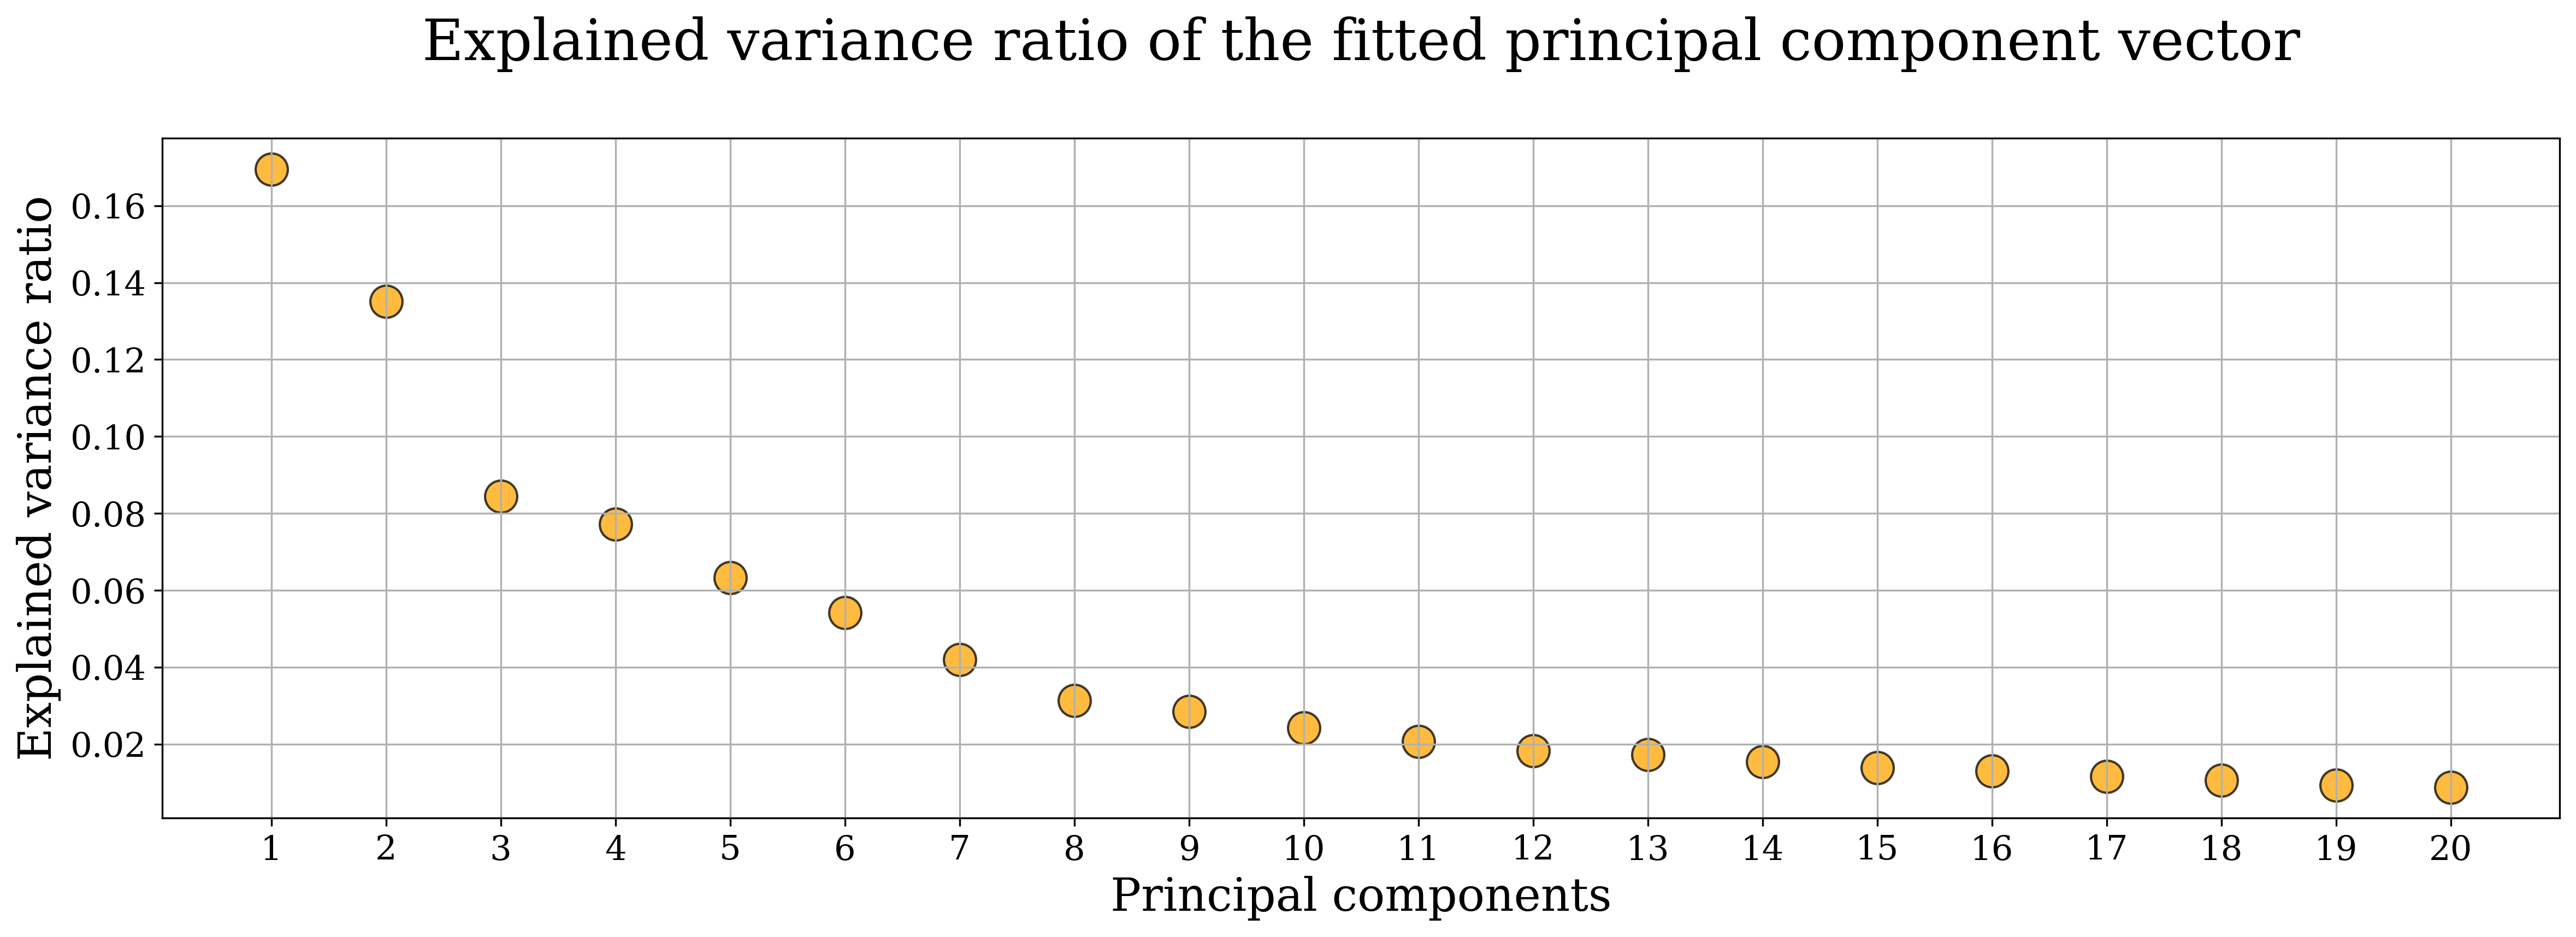

In [43]:
print("Show the first 20 principla components")
df_pca,fig_df = pca_analysis(df_variance,0)
fig_df.savefig(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset low variance explained variance ratio of the fitted PCs.png",bbox_inches='tight')
print(df_pca.explained_variance_ratio_[df_pca.explained_variance_ratio_>=0.05])

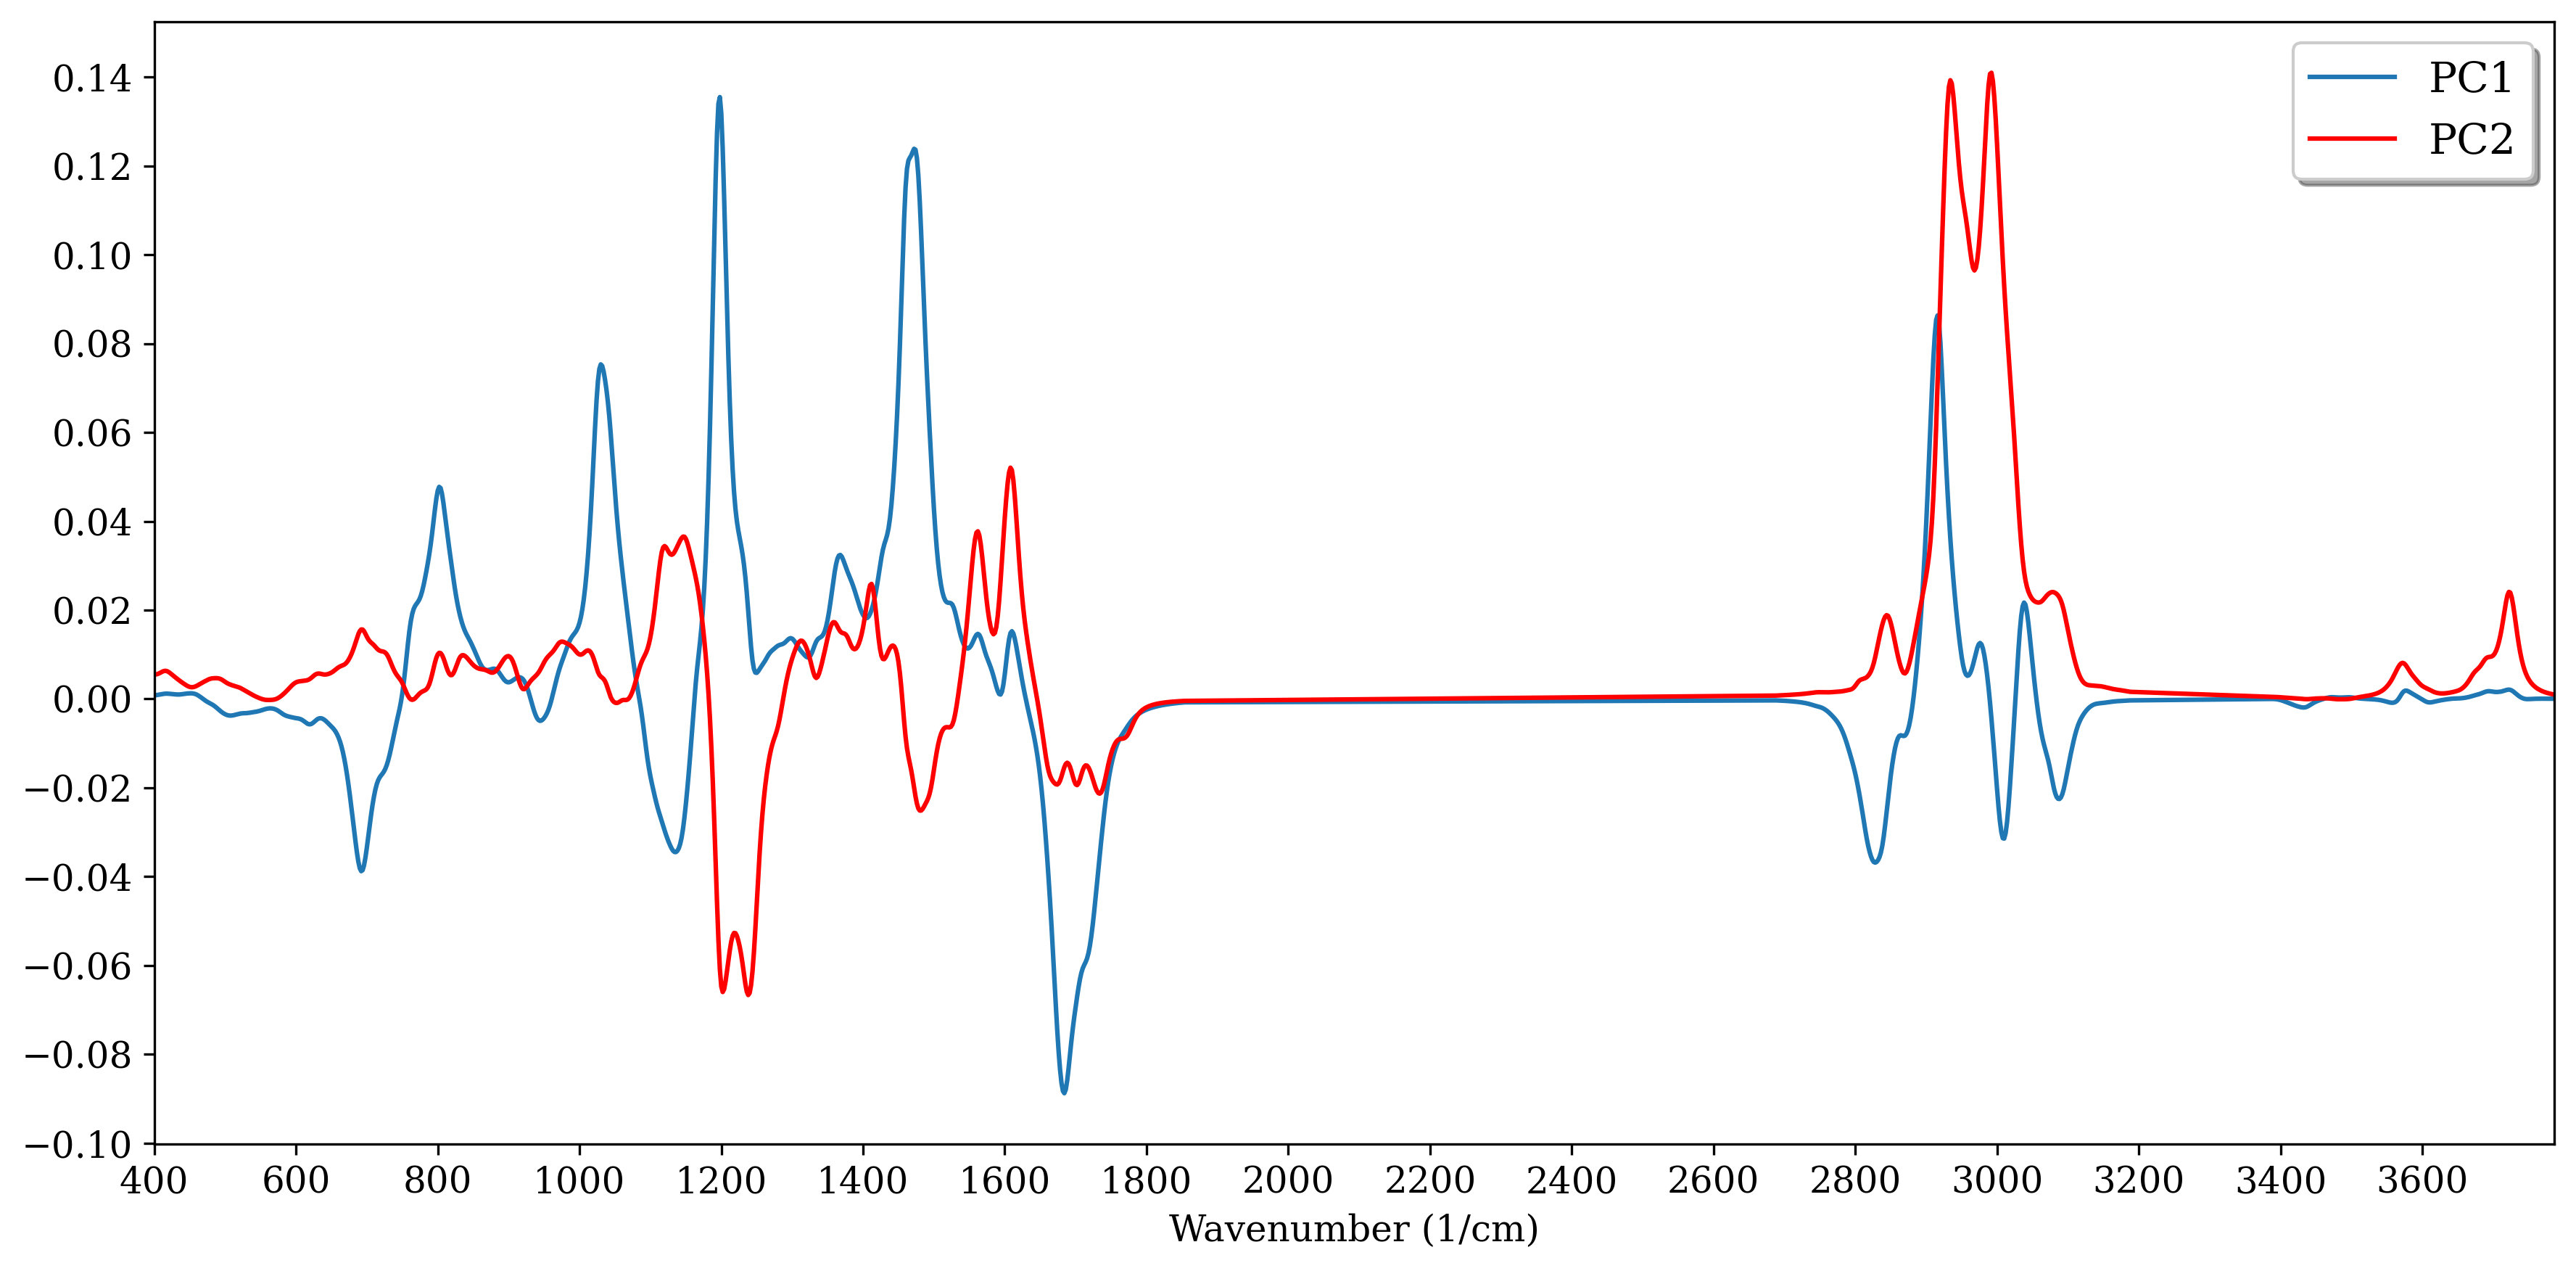

In [61]:
feature = df_variance.columns
feature = [float(item) for item in feature]
pc_loading = plot_PCs(df_pca,feature)
pc_loading.savefig(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset low variance first three PCs loading.png",bbox_inches='tight')

In [45]:
df_full_pcs = pd.DataFrame()
df_full_pcs['feature'] = feature
df_full_pcs['PC1'] = df_pca.components_[0]
df_full_pcs['PC2'] = df_pca.components_[1]
df_full_pcs['PC3'] = df_pca.components_[2]

In [48]:
df_full_pcs.to_csv(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset low variance first three PCs loading.csv", index=False)

### Use Ensemble2 subfeatures

In [49]:
df_ensemble2 = df_variance[ensemble2]

In [50]:
df_ensemble2.head()

,1234,3720,1474,2902,1182,1612,1766,3724,728,2900,...,1526,1118,1726,924,1698,796,2966,1718,1164,1478
0,0.462218,0.000107,0.105724,0.046234,0.558174,0.041192,0.358323,0.000105,0.026524,0.042680,...,0.017874,0.150606,0.204852,0.073323,0.042570,0.043972,0.204114,0.114908,0.504814,0.113158
1,0.519532,0.000103,0.103933,0.045583,0.486739,0.035260,0.398166,0.000101,0.031514,0.041970,...,0.016819,0.123761,0.286211,0.064290,0.050220,0.040263,0.197778,0.156072,0.366543,0.109121
2,0.491162,0.000099,0.098301,0.066929,0.472395,0.033915,0.392002,0.000097,0.032681,0.062031,...,0.016656,0.119987,0.287168,0.053517,0.049990,0.041159,0.181270,0.156757,0.323890,0.102595
3,0.237495,0.000090,0.100487,0.056300,0.748179,0.030534,0.466465,0.000089,0.018517,0.053635,...,0.015196,0.121476,0.062445,0.051115,0.022325,0.065730,0.176340,0.043209,0.413818,0.111431
4,0.528925,0.000124,0.202565,0.073363,0.389581,0.045850,0.715689,0.000121,0.041664,0.067062,...,0.025261,0.155798,0.295890,0.073632,0.064988,0.076088,0.235428,0.169365,0.572813,0.202181


Number of features: 175
Number of samples: 930
[0.24881645 0.13756103 0.08953795 0.0777773  0.06346025]


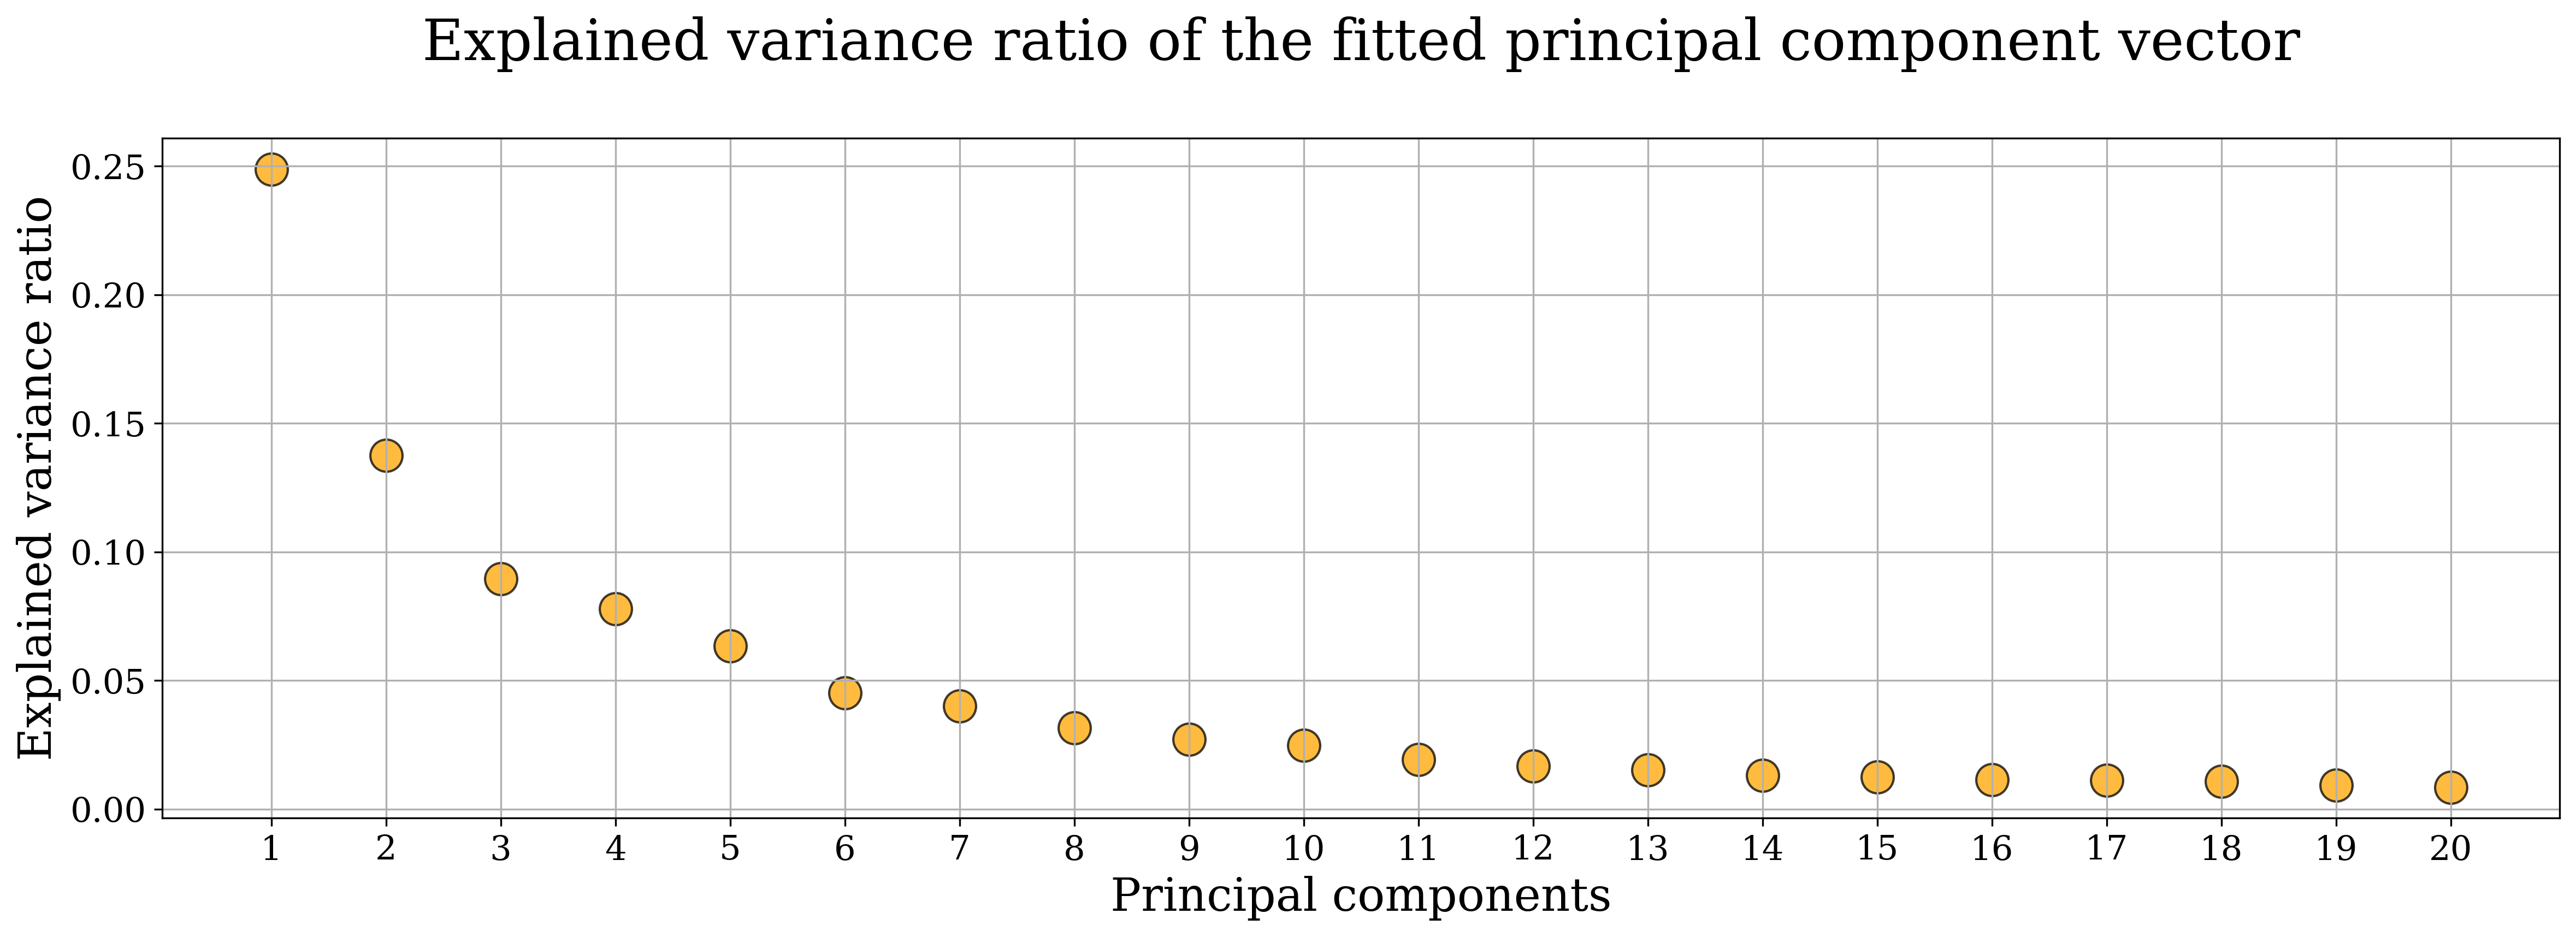

In [51]:
df_pca_ensemble,fig_df_ensemble = pca_analysis(df_ensemble2,0)
fig_df.savefig(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset low variance ensemble2 explained variance ratio of the fitted PCs.png",bbox_inches='tight')
print(df_pca_ensemble.explained_variance_ratio_[df_pca_ensemble.explained_variance_ratio_>=0.05])

In [52]:
feature = df_ensemble2
feature = [float(item) for item in feature]
idx = np.argsort(feature)
feature_sort=[]
pca1 = []
pca2 = []
pca3 = []
for i in idx:
    feature_sort.append(feature[i])
    pca1.append(df_pca_ensemble.components_[0][i])
    pca2.append(df_pca_ensemble.components_[1][i])
    pca3.append(df_pca_ensemble.components_[2][i])

In [53]:
df_ensemble2_pcs = pd.DataFrame()
df_ensemble2_pcs['feature']=feature_sort
df_ensemble2_pcs['PC1']=pca1
df_ensemble2_pcs['PC2']=pca2
df_ensemble2_pcs['PC3']=pca3

In [55]:
df_ensemble2_pcs.to_csv(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset low variance ensemble2 first three PCs loading.csv", index=False)

In [59]:
range1 = feature_sort[0:138]
print(range1[0])
print(range1[-1])

692.0
1772.0


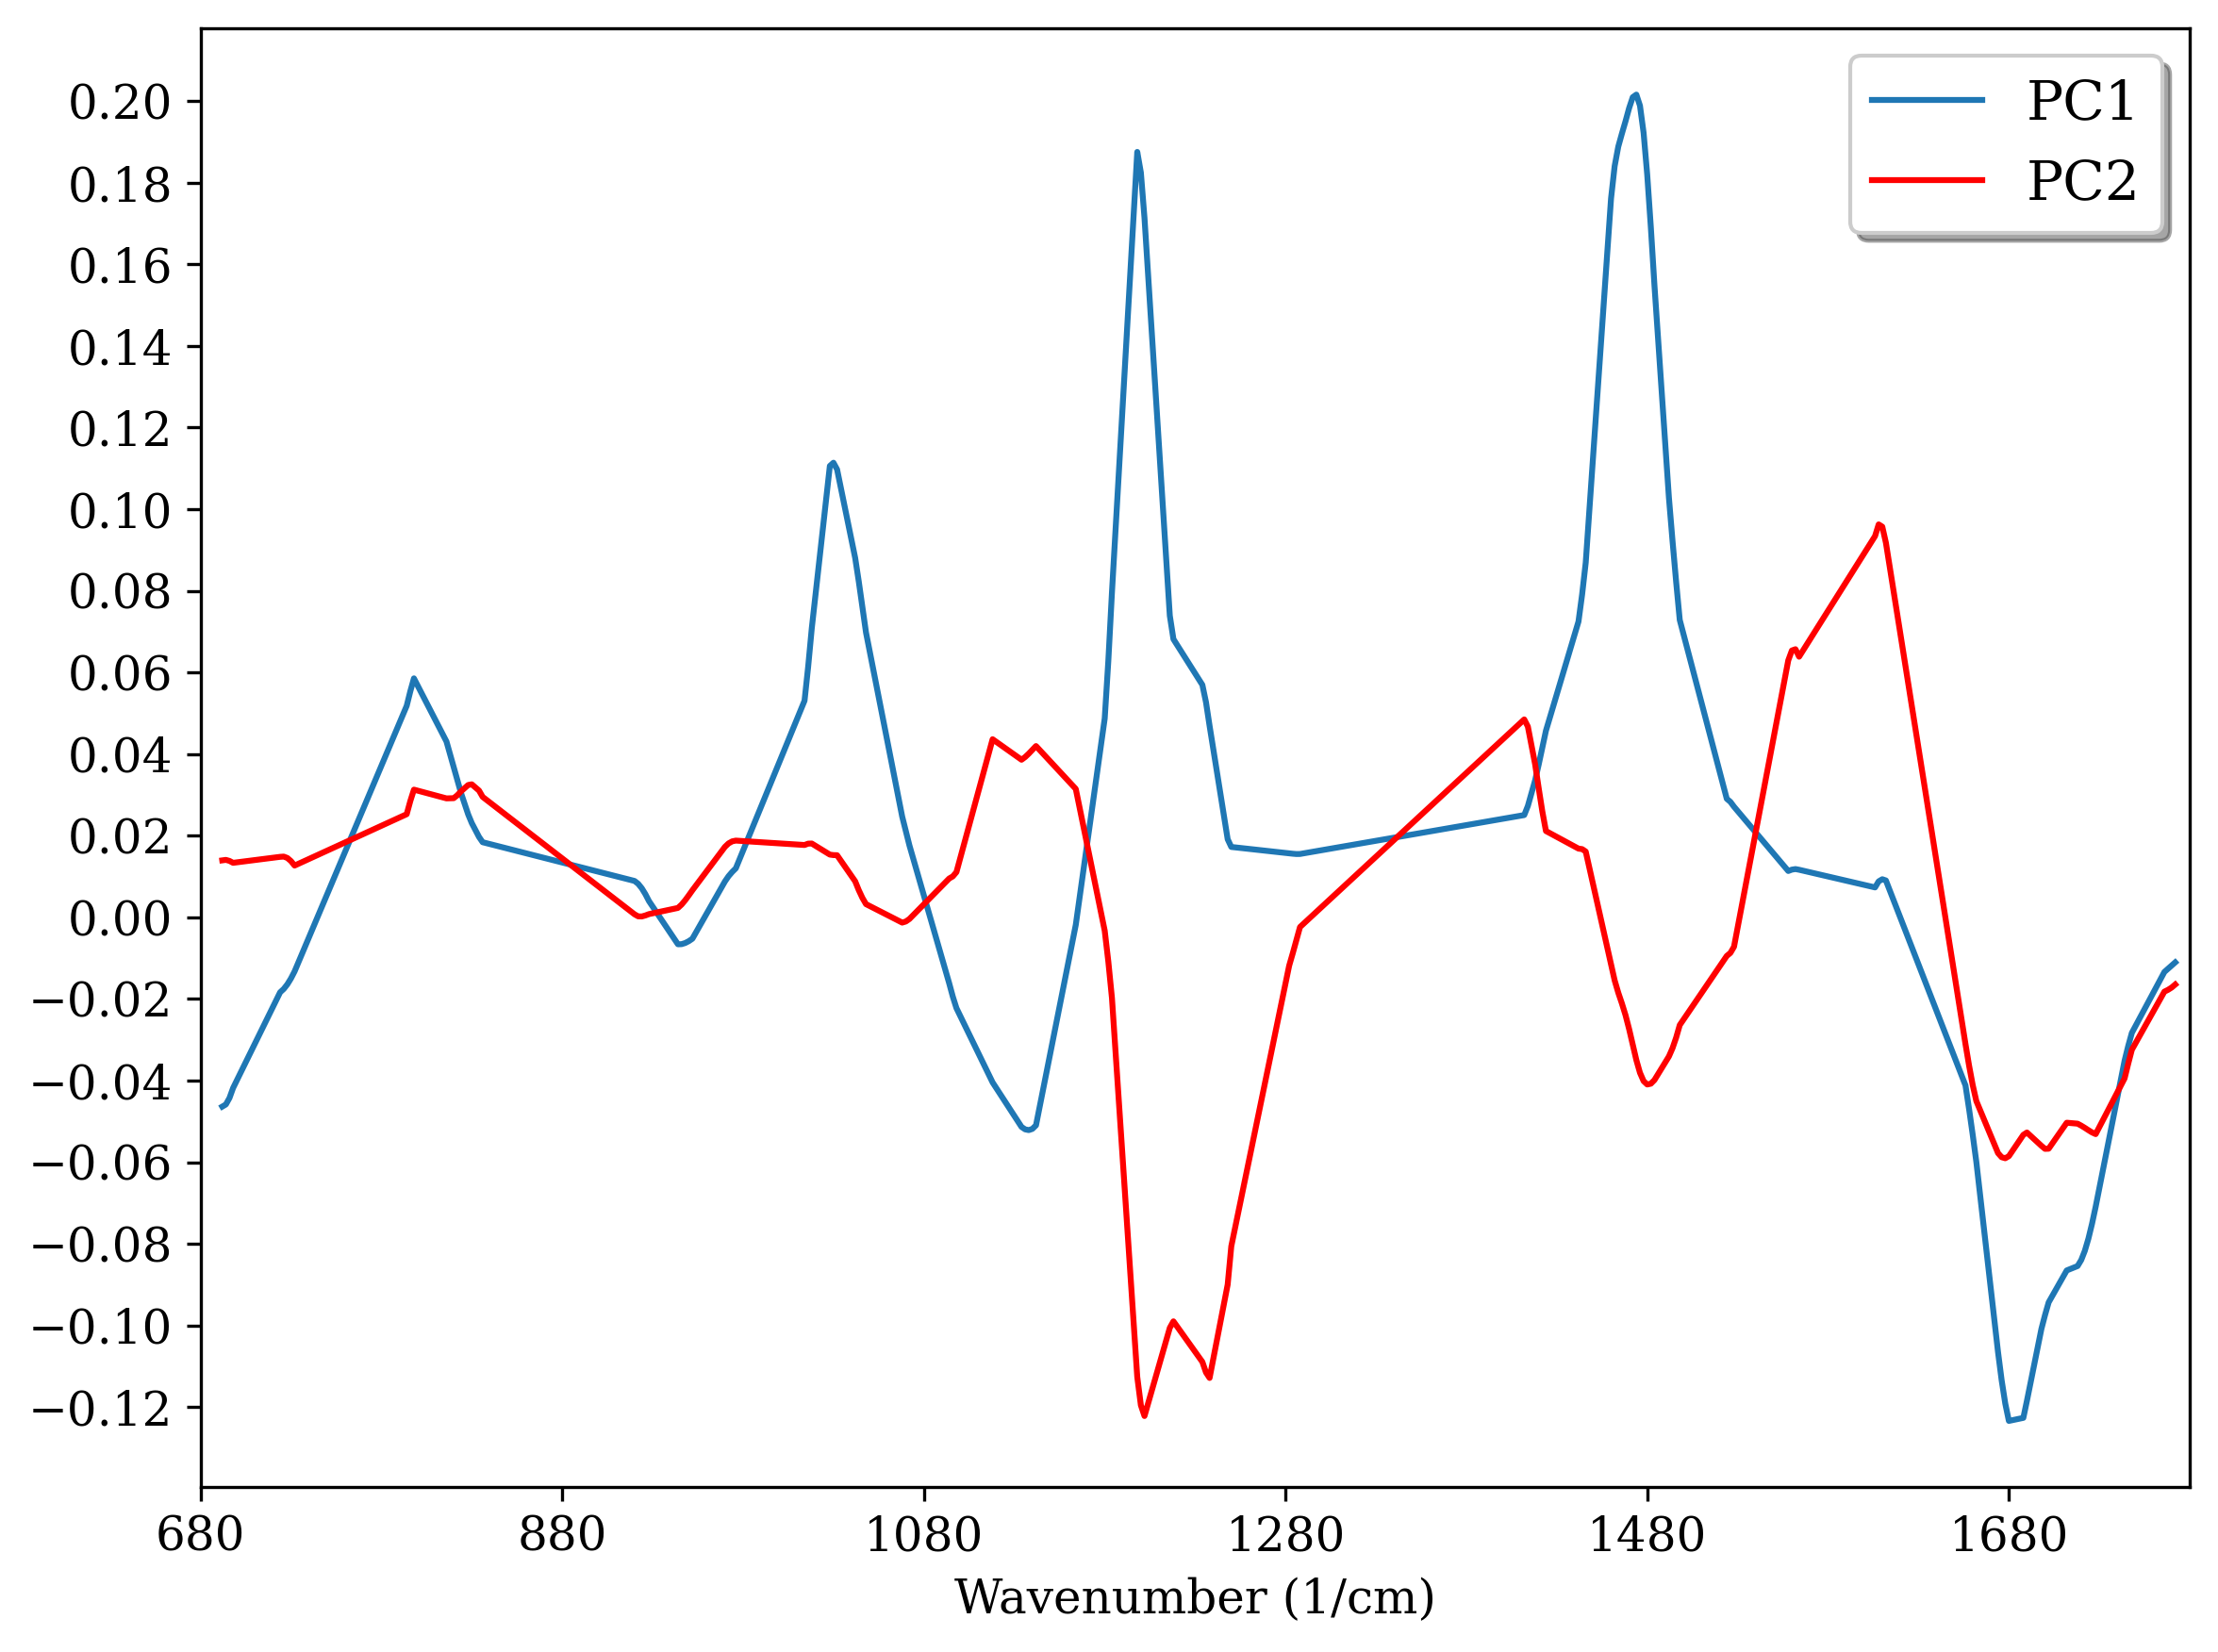

In [78]:
fig = plt.figure(figsize=(8, 6), dpi=300)
plt.rc('font', family='serif', size = 12)
plt.xlabel('Wavenumber (1/cm)')
plt.xlim(680,1780)
plt.xticks(np.arange(680, 1780,200))
plt.yticks(np.arange(-0.24,0.29,0.02))
plt.plot(range1,pca1[0:138], label="PC1")
plt.plot(range1,pca2[0:138],'r', label="PC2")
#plt.plot(range1,pca3[0:138],'k', label="PC3")
legend = plt.legend(loc='upper right', shadow=True, fontsize=14,ncol=1)
#plt.grid(True)
fig.tight_layout()
plt.show()
fig.savefig(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset low variance ensemble2 first three PCs loading - range1.png",bbox_inches='tight')

In [63]:
range2 = feature_sort[138:163]
print(range2[0])
print(range2[-1])

2822.0
3010.0


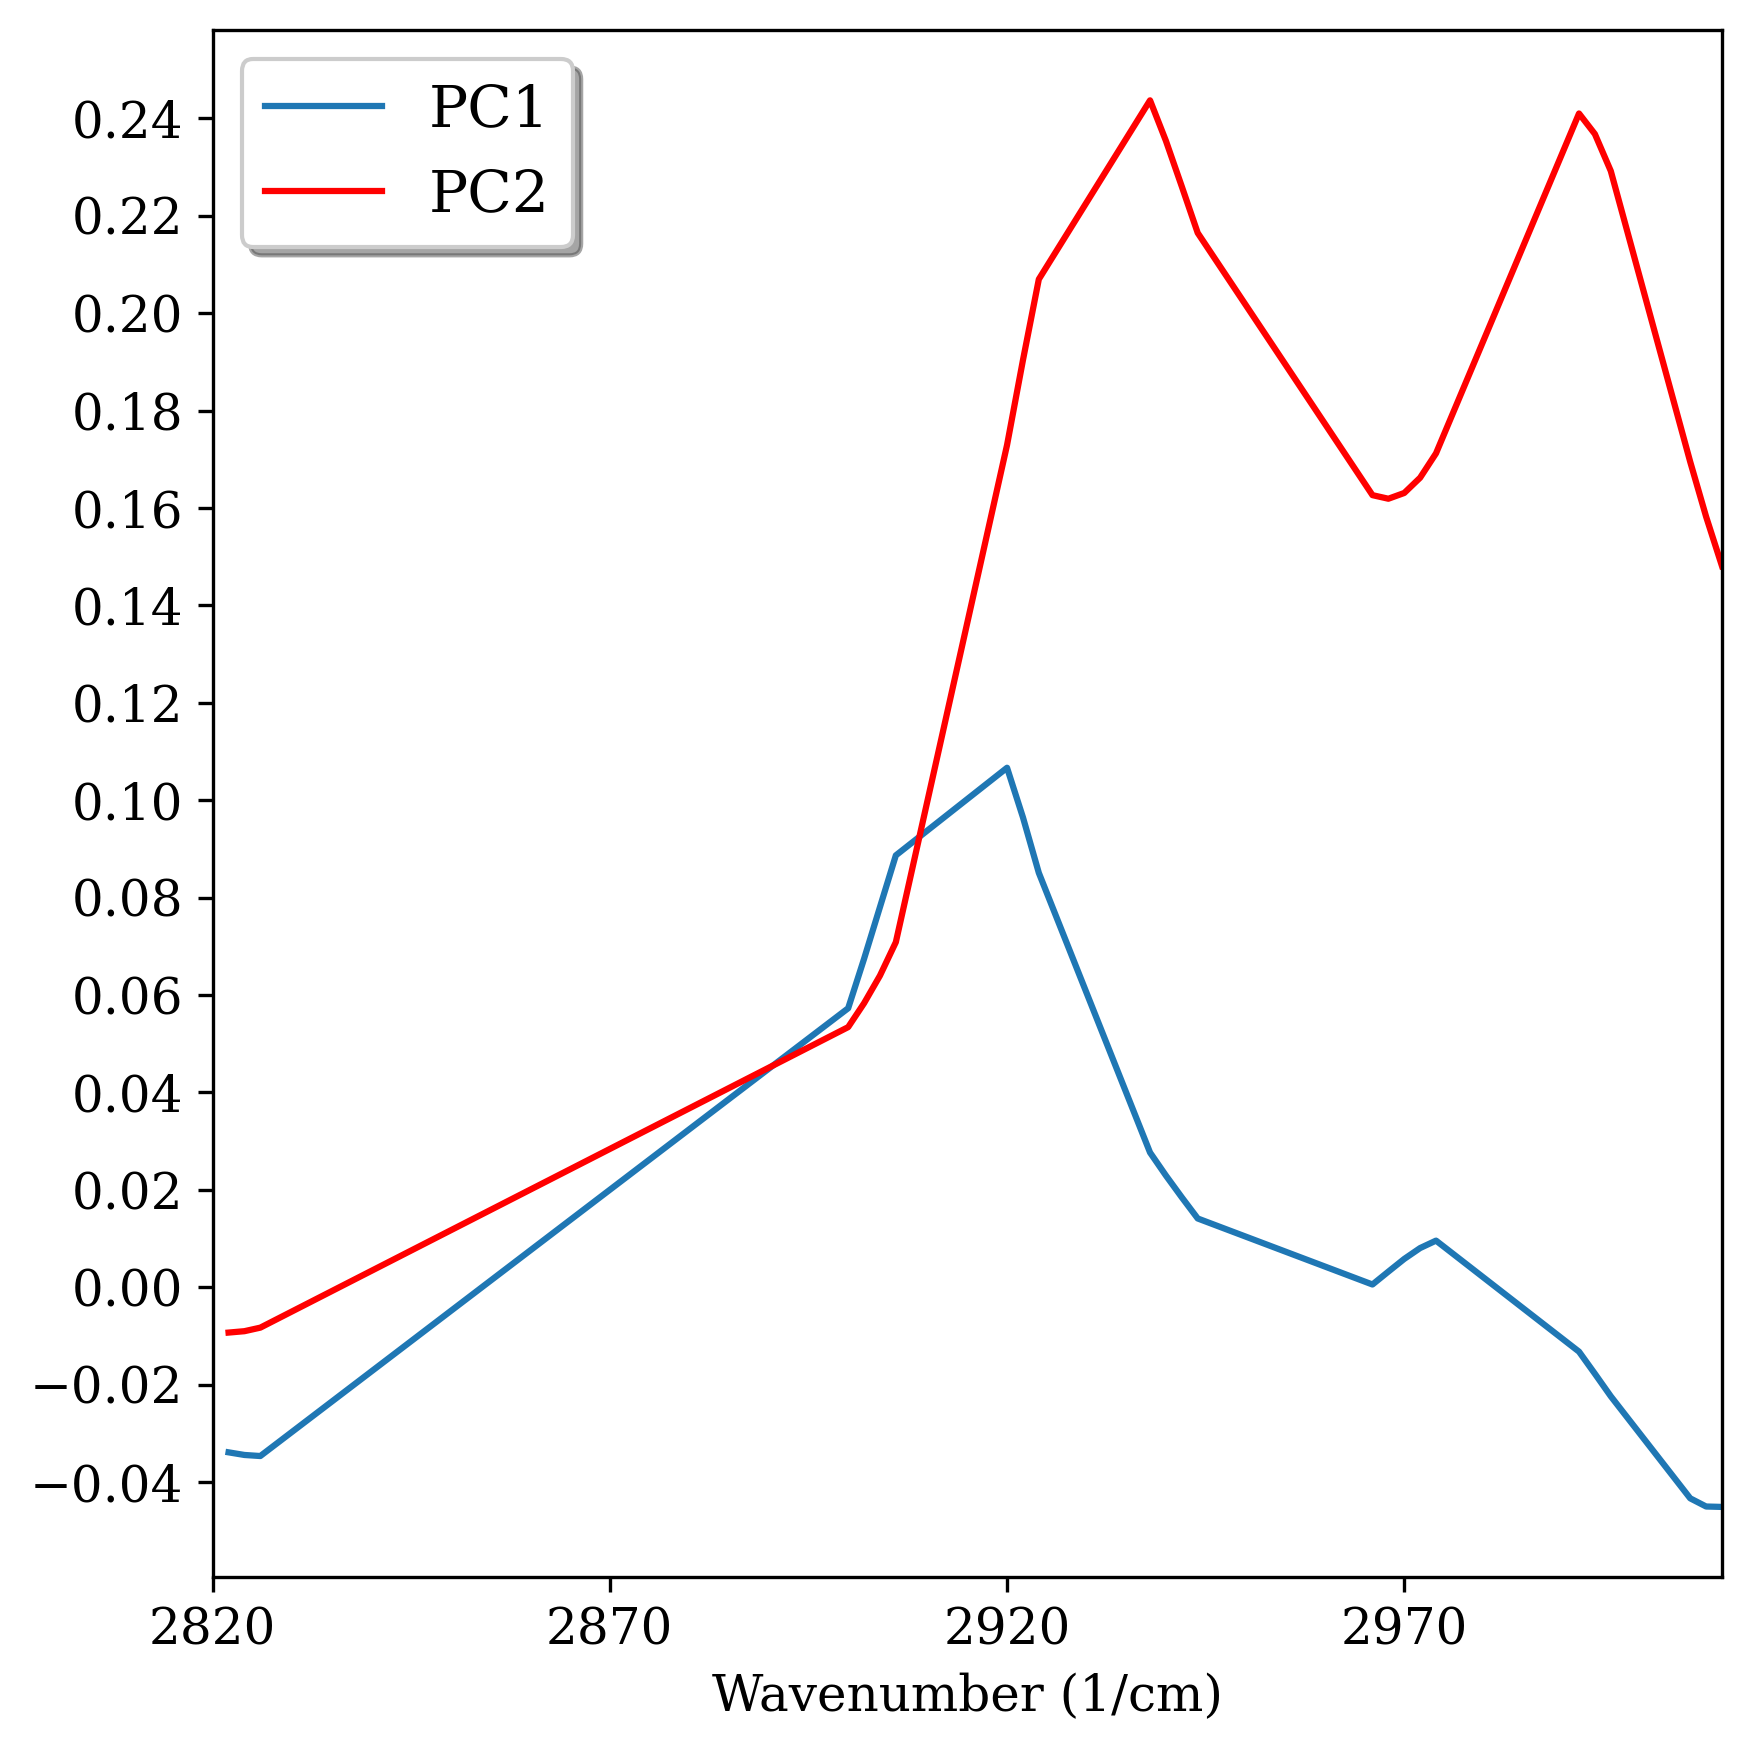

In [79]:
fig = plt.figure(figsize=(6, 6), dpi=300)
plt.rc('font', family='serif', size = 12)
plt.xlabel('Wavenumber (1/cm)')
plt.xlim(2820,3010)
plt.xticks(np.arange(2820,3010,50))
plt.yticks(np.arange(-0.24,0.29,0.02))
plt.plot(range2,pca1[138:163], label="PC1")
plt.plot(range2,pca2[138:163],'r', label="PC2")
#plt.plot(range2,pca3[138:163],'k', label="PC3")
legend = plt.legend(loc='upper left', shadow=True, fontsize=14,ncol=1)
#plt.grid(True)
fig.tight_layout()
plt.show()
fig.savefig(path+"0.971 scaled DFT 6-311++G(d,p) IR dataset low variance ensemble2 first three PCs loading - range2.png",bbox_inches='tight')